In [1]:
# Bring in the libraries
import os
import warnings
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Important for classifer models
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import svm as sv
from sklearn.preprocessing import RobustScaler # For data requiring normalization
# Classification KPIs
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
# PR AUC 
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import auc
# Vis
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline


In [2]:
os.chdir(r'..\UFC-Predictions\Data')

In [3]:
# Load in data

recent_events = pd.read_csv('most-recent-event.csv')
master = pd.read_csv('ufc-master.csv')
upcoming_events = pd.read_csv('upcoming-event.csv')
# Probs won't use
task_dummy = pd.read_csv('task-dummy.csv')

In [4]:
# Quick peak at upcoming events
upcoming_events[['total_round_dif','total_title_bout_dif','ko_dif','sub_dif','height_dif','reach_dif','age_dif','sig_str_dif',
                        'avg_sub_att_dif','avg_td_dif']].tail(20)

,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif
0,59,13,14,3,5.08,-5.08,9,-0.27,0.6,-0.23
1,27,0,3,-1,2.54,10.16,4,1.85,-2.5,0.58
2,4,0,3,-2,-5.08,0.00,-2,0.17,-0.7,0.00
3,-24,0,-2,-1,-2.54,-7.62,2,-4.69,-0.8,-0.96
4,-41,0,0,-2,-2.54,-2.54,-9,-2.45,1.2,-0.43
5,0,0,-1,0,2.54,10.16,-6,-3.95,0.0,2.15
6,-1,0,-1,0,-5.08,-12.70,2,-10.77,0.0,0.00
7,-10,0,-1,-1,-2.54,-7.62,1,-1.70,-0.5,-1.37
8,0,0,0,0,-5.08,-7.62,-3,1.73,0.0,0.00
9,5,0,0,1,2.54,10.16,0,-0.07,0.2,-0.06


In [5]:
# Keeping only relevant columns:
master = master[['Winner','title_bout','weight_class','gender','no_of_rounds','B_current_lose_streak',
                         'B_current_win_streak','B_draw','B_avg_SIG_STR_landed','B_avg_SIG_STR_pct','B_avg_SUB_ATT',
                        'B_avg_TD_landed','B_avg_TD_pct','B_longest_win_streak','B_wins','B_losses','B_total_rounds_fought',
                        'B_total_title_bouts','B_win_by_Decision_Majority','B_win_by_Decision_Split','B_win_by_Decision_Unanimous',
                        'B_win_by_KO/TKO','B_win_by_Submission','B_win_by_TKO_Doctor_Stoppage','B_Stance','B_Height_cms','B_Reach_cms',
                        'B_Weight_lbs',
                         
                         'R_current_lose_streak',
                         'R_current_win_streak','R_draw','R_avg_SIG_STR_landed','R_avg_SIG_STR_pct','R_avg_SUB_ATT',
                        'R_avg_TD_landed','R_avg_TD_pct','R_longest_win_streak','R_wins','R_losses','R_total_rounds_fought',
                        'R_total_title_bouts','R_win_by_Decision_Majority','R_win_by_Decision_Split','R_win_by_Decision_Unanimous',
                        'R_win_by_KO/TKO','R_win_by_Submission','R_win_by_TKO_Doctor_Stoppage','R_Stance','R_Height_cms','R_Reach_cms',
                        'R_Weight_lbs','R_age','B_age','lose_streak_dif','win_streak_dif','longest_win_streak_dif','win_dif','loss_dif',
                        'total_round_dif','total_title_bout_dif','ko_dif','sub_dif','height_dif','reach_dif','age_dif','sig_str_dif',
                        'avg_sub_att_dif','avg_td_dif','B_match_weightclass_rank','R_match_weightclass_rank','better_rank','finish',
                         # can use finish info and round stop for round end model
                        'finish_details','finish_round','finish_round_time','total_fight_time_secs']]

In [6]:
master.head()

,Winner,title_bout,weight_class,gender,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,...,avg_sub_att_dif,avg_td_dif,B_match_weightclass_rank,R_match_weightclass_rank,better_rank,finish,finish_details,finish_round,finish_round_time,total_fight_time_secs
0,Red,True,Lightweight,MALE,5,0,4,0,7.74,0.59,...,-0.7,-5.35,1.0,0.0,Red,NaN,NaN,NaN,NaN,NaN
1,Red,False,Middleweight,MALE,3,0,3,0,3.72,0.51,...,0.0,-0.28,2.0,1.0,Red,NaN,NaN,NaN,NaN,NaN
2,Red,False,Heavyweight,MALE,3,1,0,0,2.97,0.39,...,0.0,-0.40,10.0,7.0,Red,NaN,NaN,NaN,NaN,NaN
3,Blue,False,Middleweight,MALE,3,0,1,0,3.47,0.46,...,0.0,1.74,NaN,NaN,neither,NaN,NaN,NaN,NaN,NaN
4,Red,False,Women's Flyweight,FEMALE,3,0,0,0,0.00,0.00,...,0.0,-1.14,NaN,5.0,Red,NaN,NaN,NaN,NaN,NaN


In [7]:
# Looking at data types and evaluating what needs to be transformed
master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4443 entries, 0 to 4442
Data columns (total 76 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Winner                        4443 non-null   object 
 1   title_bout                    4443 non-null   bool   
 2   weight_class                  4443 non-null   object 
 3   gender                        4443 non-null   object 
 4   no_of_rounds                  4443 non-null   int64  
 5   B_current_lose_streak         4443 non-null   int64  
 6   B_current_win_streak          4443 non-null   int64  
 7   B_draw                        4443 non-null   int64  
 8   B_avg_SIG_STR_landed          3513 non-null   float64
 9   B_avg_SIG_STR_pct             3678 non-null   float64
 10  B_avg_SUB_ATT                 3611 non-null   float64
 11  B_avg_TD_landed               3610 non-null   float64
 12  B_avg_TD_pct                  3601 non-null   float64
 13  B_l

## Consolidating and Creating Variables

In [8]:
# Making concise victory conditions:

#Decision:
master['B_win_by_Decision'] = master['B_win_by_Decision_Majority'] + master['B_win_by_Decision_Split'] + master['B_win_by_Decision_Unanimous']
master['R_win_by_Decision'] = master['R_win_by_Decision_Majority'] + master['R_win_by_Decision_Split'] + master['R_win_by_Decision_Unanimous']
master = master.drop(['B_win_by_Decision_Majority','B_win_by_Decision_Split','B_win_by_Decision_Unanimous','R_win_by_Decision_Majority','R_win_by_Decision_Split','R_win_by_Decision_Unanimous'],axis=1)

# KO
master['B_win_by_KO'] = master['B_win_by_KO/TKO'] + master['B_win_by_TKO_Doctor_Stoppage']
master['R_win_by_KO'] = master['R_win_by_KO/TKO'] + master['R_win_by_TKO_Doctor_Stoppage']
master = master.drop(['B_win_by_KO/TKO','B_win_by_TKO_Doctor_Stoppage','R_win_by_KO/TKO','R_win_by_TKO_Doctor_Stoppage'],axis=1)

In [9]:
# Setting winner to binary: Blue = 0, Red = 1
master['Winner'] = master['Winner'].apply(lambda x: 0 if x == 'Blue' else 1)

In [10]:
# Creating Additional dif variables:
master['rank_dif'] = master['B_match_weightclass_rank'] - master['R_match_weightclass_rank']
master['weight_lbs_dif'] = master['B_Weight_lbs'] - master['R_Weight_lbs']

## Adjusting Categorical Vars

In [11]:
# Cleaning up stances
master['B_Stance'].value_counts()

Orthodox       3344
Southpaw        900
Switch          197
Open Stance       1
Switch            1
Name: B_Stance, dtype: int64

In [12]:
master['R_Stance'].value_counts()

Orthodox       3389
Southpaw        898
Switch          152
Open Stance       4
Name: R_Stance, dtype: int64

In [13]:
master['B_Stance'].replace(r' ','',regex=True,inplace=True)

In [14]:
master['B_Stance'].value_counts()

Orthodox      3344
Southpaw       900
Switch         198
OpenStance       1
Name: B_Stance, dtype: int64

In [15]:
# Stances
master_cat = master[['B_Stance','R_Stance']]
master_cat_dummy = pd.get_dummies(master_cat)
# Bring back together and remove old
master = master.merge(master_cat_dummy, left_index=True,right_index=True)
master = master.drop(['B_Stance','R_Stance'],axis=1)

In [16]:
# Clear up the NaN and view
master = master.replace(np.nan, 0)
master.head()

,Winner,title_bout,weight_class,gender,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,...,rank_dif,weight_lbs_dif,B_Stance_OpenStance,B_Stance_Orthodox,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Southpaw,R_Stance_Switch
0,1,True,Lightweight,MALE,5,0,4,0,7.74,0.59,...,1.0,0,0,1,0,0,0,1,0,0
1,1,False,Middleweight,MALE,3,0,3,0,3.72,0.51,...,1.0,0,0,0,0,1,0,1,0,0
2,1,False,Heavyweight,MALE,3,1,0,0,2.97,0.39,...,3.0,0,0,0,1,0,0,1,0,0
3,0,False,Middleweight,MALE,3,0,1,0,3.47,0.46,...,0.0,0,0,1,0,0,0,1,0,0
4,1,False,Women's Flyweight,FEMALE,3,0,0,0,0.00,0.00,...,0.0,0,0,1,0,0,0,1,0,0


In [17]:
# Split up the genders:
m_master = master[master['gender'] == 'MALE']
m_master = m_master.drop(['gender'], axis = 1)
f_master = master[master['gender'] == 'FEMALE']
f_master = f_master.drop(['gender'], axis = 1)

In [18]:
m_master.head()

,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,...,rank_dif,weight_lbs_dif,B_Stance_OpenStance,B_Stance_Orthodox,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Southpaw,R_Stance_Switch
0,1,True,Lightweight,5,0,4,0,7.74,0.59,0.0,...,1.0,0,0,1,0,0,0,1,0,0
1,1,False,Middleweight,3,0,3,0,3.72,0.51,0.0,...,1.0,0,0,0,0,1,0,1,0,0
2,1,False,Heavyweight,3,1,0,0,2.97,0.39,0.2,...,3.0,0,0,0,1,0,0,1,0,0
3,0,False,Middleweight,3,0,1,0,3.47,0.46,0.0,...,0.0,0,0,1,0,0,0,1,0,0
5,1,False,Light Heavyweight,3,1,0,0,5.29,0.39,0.0,...,0.0,0,0,0,1,0,0,1,0,0


In [19]:
f_master.head()

,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,...,rank_dif,weight_lbs_dif,B_Stance_OpenStance,B_Stance_Orthodox,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Southpaw,R_Stance_Switch
4,1,False,Women's Flyweight,3,0,0,0,0.00,0.00,0.0,...,0.0,0,0,1,0,0,0,1,0,0
9,0,False,Women's Flyweight,3,0,0,0,0.00,0.00,0.0,...,0.0,0,0,0,1,0,0,1,0,0
12,0,False,Women's Flyweight,3,2,0,0,6.40,0.49,0.4,...,1.0,-10,0,1,0,0,0,1,0,0
17,1,False,Women's Flyweight,3,0,1,0,3.65,0.58,0.0,...,0.0,-10,0,1,0,0,0,1,0,0
33,1,False,Women's Bantamweight,3,0,0,0,0.00,0.00,0.0,...,0.0,0,0,1,0,0,0,1,0,0


In [20]:
# Title_bout / # of total rounds? Would that be necessary or is it alright as is?

In [21]:
# Methods of victory

# Winner Model:
* Utilizes binary classfication models
* Old Work: https://dataplatform.cloud.ibm.com/analytics/notebooks/v2/a7f894ab-27b9-4075-9131-5f706ca2b602/view?projectid=7de0f00d-a114-4cd1-a5ae-ef5f4ca012b5&context=cpdaas

In [22]:
# Creating different potentially important datasets


# Base Stats
m_winner_base = m_master[['weight_class','Winner','B_current_lose_streak',
                         'B_current_win_streak','B_draw','B_avg_SIG_STR_landed','B_avg_SIG_STR_pct','B_avg_SUB_ATT',
                        'B_avg_TD_landed','B_avg_TD_pct','B_wins','B_losses','B_total_rounds_fought',
                        'B_total_title_bouts','B_Height_cms','B_Reach_cms','B_age',
                        'B_Weight_lbs','B_win_by_Decision','B_win_by_KO','B_Weight_lbs','B_match_weightclass_rank',
                              
                        'R_current_lose_streak',
                         'R_current_win_streak','R_draw','R_avg_SIG_STR_landed','R_avg_SIG_STR_pct','R_avg_SUB_ATT',
                        'R_avg_TD_landed','R_avg_TD_pct','R_wins','R_losses','R_total_rounds_fought',
                        'R_total_title_bouts','R_Height_cms','R_Reach_cms','R_age',
                        'R_Weight_lbs','R_win_by_Decision','R_win_by_KO','R_Weight_lbs','R_match_weightclass_rank']]

# Fighter differences (Blue - Red)
m_winner_b2r = m_master[['weight_class','Winner','lose_streak_dif','win_streak_dif','longest_win_streak_dif','win_dif','loss_dif',
                        'total_round_dif','total_title_bout_dif','ko_dif','sub_dif','height_dif','reach_dif','age_dif','sig_str_dif',
                        'avg_sub_att_dif','avg_td_dif','rank_dif','weight_lbs_dif']]



fighter_columns = ['weight_class','Winner','current_lose_streak',
                         'current_win_streak','draw','avg_SIG_STR_landed','avg_SIG_STR_pct','avg_SUB_ATT',
                        'avg_TD_landed','avg_TD_pct','wins','losses','total_rounds_fought',
                        'total_title_bouts','Height_cms','Reach_cms', 'Age',
                        'Weight_lbs','win_by_Decision','win_by_KO','Weight_lbs','match_weightclass_rank']

# Blue fighter stats
m_winner_bf = m_master[['weight_class','Winner','B_current_lose_streak',
                         'B_current_win_streak','B_draw','B_avg_SIG_STR_landed','B_avg_SIG_STR_pct','B_avg_SUB_ATT',
                        'B_avg_TD_landed','B_avg_TD_pct','B_wins','B_losses','B_total_rounds_fought',
                        'B_total_title_bouts','B_Height_cms','B_Reach_cms', 'B_age',
                        'B_Weight_lbs','B_win_by_Decision','B_win_by_KO','B_Weight_lbs','B_match_weightclass_rank']]

m_winner_bf.columns = fighter_columns

# Red winners' stats 
m_winner_rf = m_master[['weight_class','Winner','R_current_lose_streak',
                         'R_current_win_streak','R_draw','R_avg_SIG_STR_landed','R_avg_SIG_STR_pct','R_avg_SUB_ATT',
                        'R_avg_TD_landed','R_avg_TD_pct','R_wins','R_losses','R_total_rounds_fought',
                        'R_total_title_bouts','R_Height_cms','R_Reach_cms', 'R_age',
                        'R_Weight_lbs','R_win_by_Decision','R_win_by_KO','R_Weight_lbs','R_match_weightclass_rank']]

m_winner_rf.columns = fighter_columns

# Final clean up

# Blue
m_winner_bw = m_winner_bf[m_winner_bf['Winner'] == 0]
m_winner_bw = m_winner_bw.drop(['Winner'], axis = 1)

# Red
m_winner_rw = m_winner_rf[m_winner_rf['Winner'] == 1]
m_winner_rw = m_winner_rw.drop(['Winner'], axis = 1)

In [23]:
# Base
m_winner_base.head()

,weight_class,Winner,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_landed,B_avg_TD_pct,...,R_total_rounds_fought,R_total_title_bouts,R_Height_cms,R_Reach_cms,R_age,R_Weight_lbs,R_win_by_Decision,R_win_by_KO,R_Weight_lbs,R_match_weightclass_rank
0,Lightweight,1,0,4,0,7.74,0.59,0.0,0.00,0.00,...,36,3,177.80,177.80,32,155,6,2,155,0.0
1,Middleweight,1,0,3,0,3.72,0.51,0.0,0.18,0.33,...,42,2,182.88,185.42,29,185,7,5,185,1.0
2,Heavyweight,1,1,0,0,2.97,0.39,0.2,0.32,0.33,...,24,0,200.66,203.20,32,250,3,2,250,7.0
3,Middleweight,0,0,1,0,3.47,0.46,0.0,1.74,0.14,...,0,0,175.26,185.42,25,185,0,0,185,0.0
5,Light Heavyweight,1,1,0,0,5.29,0.39,0.0,2.59,0.71,...,11,0,190.50,190.50,28,205,1,3,205,11.0


In [24]:
# Difs
m_winner_b2r.head()

,weight_class,Winner,lose_streak_dif,win_streak_dif,longest_win_streak_dif,win_dif,loss_dif,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif,rank_dif,weight_lbs_dif
0,Lightweight,1,0,-8,-8,-7,2,-19,-2,3,-4,2.54,0.00,-1,3.63,-0.7,-5.35,1.0,0
1,Middleweight,1,0,2,-6,-6,1,-22,-2,0,0,-2.54,10.16,7,-0.79,0.0,-0.28,1.0,0
2,Heavyweight,1,0,0,-1,1,5,0,0,4,0,-5.08,-7.62,5,-1.68,0.0,-0.40,3.0,0
3,Middleweight,0,0,1,1,1,1,3,0,1,0,7.62,10.16,6,3.47,0.0,1.74,0.0,0
5,Light Heavyweight,1,1,-4,-2,0,3,4,0,0,0,-5.08,0.00,-2,1.83,0.0,1.91,0.0,0


In [25]:
# Blue Winners
m_winner_bw.head()

,weight_class,current_lose_streak,current_win_streak,draw,avg_SIG_STR_landed,avg_SIG_STR_pct,avg_SUB_ATT,avg_TD_landed,avg_TD_pct,wins,...,total_rounds_fought,total_title_bouts,Height_cms,Reach_cms,Age,Weight_lbs,win_by_Decision,win_by_KO,Weight_lbs,match_weightclass_rank
3,Middleweight,0,1,0,3.47,0.46,0.0,1.74,0.14,1,...,3,0,182.88,195.58,31,185,0,1,185,0.0
6,Heavyweight,3,0,0,4.09,0.48,0.0,0.00,0.00,3,...,12,0,187.96,190.50,27,264,1,2,264,0.0
7,Catch Weight,0,2,0,4.25,0.42,0.6,1.13,0.46,5,...,19,0,170.18,172.72,29,140,4,0,140,0.0
8,Welterweight,0,0,0,0.00,0.00,0.0,0.00,0.00,0,...,0,0,185.42,195.58,26,170,0,0,170,0.0
14,Welterweight,1,0,0,4.65,0.48,1.0,1.05,0.18,8,...,33,0,187.96,185.42,34,170,3,3,170,0.0


In [26]:
# Red Winners
m_winner_rw.head()

,weight_class,current_lose_streak,current_win_streak,draw,avg_SIG_STR_landed,avg_SIG_STR_pct,avg_SUB_ATT,avg_TD_landed,avg_TD_pct,wins,...,total_rounds_fought,total_title_bouts,Height_cms,Reach_cms,Age,Weight_lbs,win_by_Decision,win_by_KO,Weight_lbs,match_weightclass_rank
0,Lightweight,0,12,0,4.11,0.49,0.7,5.35,0.47,12,...,36,3,177.80,177.80,32,155,6,2,155,0.0
1,Middleweight,0,1,0,4.51,0.40,0.0,0.46,0.30,12,...,42,2,182.88,185.42,29,185,7,5,185,1.0
2,Heavyweight,1,0,0,4.65,0.58,0.2,0.72,0.70,5,...,24,0,200.66,203.20,32,250,3,2,250,7.0
5,Light Heavyweight,0,4,0,3.46,0.56,0.0,0.68,0.33,4,...,11,0,190.50,190.50,28,205,1,3,205,11.0
10,Lightweight,0,2,0,3.03,0.36,0.6,0.00,0.00,2,...,6,0,190.50,195.58,26,155,0,1,155,0.0


## Exploratory Data Analysis (EDA):

In [27]:
# Blue Fighter Records
m_winner_bf[['weight_class','wins','losses','draw']].groupby('weight_class').describe()


wins                                               losses  \
                   count      mean       std  min  25%  50%  75%   max  count   
weight_class                                                                    
Bantamweight       439.0  1.931663  2.523836  0.0  0.0  1.0  3.0  18.0  439.0   
Catch Weight        26.0  2.461538  3.754792  0.0  0.0  1.0  2.0  13.0   26.0   
Featherweight      517.0  2.574468  3.349876  0.0  0.0  1.0  4.0  17.0  517.0   
Flyweight          212.0  2.023585  2.702362  0.0  0.0  1.0  3.0  21.0  212.0   
Heavyweight        347.0  3.285303  4.060509  0.0  0.0  2.0  5.0  22.0  347.0   
Light Heavyweight  361.0  3.531856  3.798349  0.0  0.0  3.0  5.0  19.0  361.0   
Lightweight        803.0  2.992528  3.822097  0.0  0.0  1.0  4.0  23.0  803.0   
Middleweight       535.0  3.269159  3.688031  0.0  0.0  2.0  5.0  19.0  535.0   
Welterweight       772.0  3.238342  3.911496  0.0  0.0  2.0  5.0  29.0  772.0   

                             ...              draw                           \
                       mean  ...  75%   max  count      mean       std  min   
weight_class                 ...                                              
Bantamweight       1.220957  ...  2.0   8.0  439.0  0.002278  0.047727  0.0   
Catch Weight       1.461538  ...  2.0   7.0   26.0  0.000000  0.000000  0.0   
Featherweight      1.700193  ...  2.0  15.0  517.0  0.013540  0.115682  0.0   
Flyweight          1.169811  ...  2.0   6.0  212.0  0.014151  0.118393  0.0   
Heavyweight        1.766571  ...  3.0  10.0  347.0  0.000000  0.000000  0.0   
Light Heavyweight  2.022161  ...  3.0  11.0  361.0  0.000000  0.000000  0.0   
Lightweight        1.836862  ...  3.0  13.0  803.0  0.007472  0.099595  0.0   
Middleweight       1.940187  ...  3.0  10.0  535.0  0.007477  0.086224  0.0   
Welterweight       1.841969  ...  3.0  14.0  772.0  0.001295  0.035991  0.0   

                                       
                   25%  50%  75%  max  
weight_class                           
Bantamweight       0.0  0.0  0.0  1.0  
Catch Weight       0.0  0.0  0.0  0.0  
Featherweight      0.0  0.0  0.0  1.0  
Flyweight          0.0  0.0  0.0  1.0  
Heavyweight        0.0  0.0  0.0  0.0  
Light Heavyweight  0.0  0.0  0.0  0.0  
Lightweight        0.0  0.0  0.0  2.0  
Middleweight       0.0  0.0  0.0  1.0  
Welterweight       0.0  0.0  0.0  1.0  

[9 rows x 24 columns]

In [28]:
# Red Fighters
m_winner_rf[['weight_class','wins','losses','draw']].groupby('weight_class').describe()


wins                                               losses  \
                   count      mean       std  min  25%  50%  75%   max  count   
weight_class                                                                    
Bantamweight       439.0  2.917995  2.957479  0.0  1.0  2.0  4.0  19.0  439.0   
Catch Weight        26.0  4.307692  4.798077  0.0  1.0  3.0  5.0  20.0   26.0   
Featherweight      517.0  3.721470  3.858418  0.0  1.0  2.0  6.0  17.0  517.0   
Flyweight          212.0  3.438679  3.365706  0.0  1.0  3.0  5.0  21.0  212.0   
Heavyweight        347.0  4.976945  4.948234  0.0  1.0  3.0  8.0  32.0  347.0   
Light Heavyweight  361.0  4.642659  4.213373  0.0  1.0  4.0  7.0  26.0  361.0   
Lightweight        803.0  4.679950  4.312995  0.0  1.0  3.0  7.0  29.0  803.0   
Middleweight       535.0  4.476636  4.160960  0.0  1.0  3.0  7.0  20.0  535.0   
Welterweight       772.0  5.068653  4.752412  0.0  1.0  4.0  7.0  22.0  772.0   

                             ...              draw                           \
                       mean  ...  75%   max  count      mean       std  min   
weight_class                 ...                                              
Bantamweight       1.738041  ...  3.0   9.0  439.0  0.002278  0.047727  0.0   
Catch Weight       2.500000  ...  4.5  13.0   26.0  0.038462  0.196116  0.0   
Featherweight      2.110251  ...  3.0  16.0  517.0  0.005803  0.076028  0.0   
Flyweight          1.863208  ...  2.0   9.0  212.0  0.004717  0.068680  0.0   
Heavyweight        2.714697  ...  4.0  17.0  347.0  0.000000  0.000000  0.0   
Light Heavyweight  2.493075  ...  4.0  11.0  361.0  0.005540  0.074329  0.0   
Lightweight        2.645081  ...  4.0  14.0  803.0  0.011208  0.126822  0.0   
Middleweight       2.450467  ...  4.0  11.0  535.0  0.007477  0.086224  0.0   
Welterweight       2.641192  ...  4.0  13.0  772.0  0.006477  0.080269  0.0   

                                       
                   25%  50%  75%  max  
weight_class                           
Bantamweight       0.0  0.0  0.0  1.0  
Catch Weight       0.0  0.0  0.0  1.0  
Featherweight      0.0  0.0  0.0  1.0  
Flyweight          0.0  0.0  0.0  1.0  
Heavyweight        0.0  0.0  0.0  0.0  
Light Heavyweight  0.0  0.0  0.0  1.0  
Lightweight        0.0  0.0  0.0  2.0  
Middleweight       0.0  0.0  0.0  1.0  
Welterweight       0.0  0.0  0.0  1.0  

[9 rows x 24 columns]

In [29]:
# Disregarding caveat, it is okay
warnings.filterwarnings('ignore')

# Blue Fighters
m_winner_bf['Color'] = 'Blue'
m_winner_bf['Win/Loss'] = m_winner_bf['Winner'].apply(lambda x: 'Win' if x == 0 else 'Loss')

# Red Fighters
m_winner_rf['Color'] = 'Red'
m_winner_rf['Win/Loss'] = m_winner_rf['Winner'].apply(lambda x: 'Win' if x == 1 else 'Loss')

m_winner_f = pd.concat([m_winner_bf, m_winner_rf])


In [30]:
# All fighters ready for analysis
m_winner_f.head()

,weight_class,Winner,current_lose_streak,current_win_streak,draw,avg_SIG_STR_landed,avg_SIG_STR_pct,avg_SUB_ATT,avg_TD_landed,avg_TD_pct,...,Height_cms,Reach_cms,Age,Weight_lbs,win_by_Decision,win_by_KO,Weight_lbs,match_weightclass_rank,Color,Win/Loss
0,Lightweight,1,0,4,0,7.74,0.59,0.0,0.00,0.00,...,180.34,177.80,31,155,0,5,155,1.0,Blue,Loss
1,Middleweight,1,0,3,0,3.72,0.51,0.0,0.18,0.33,...,180.34,195.58,36,185,1,5,185,2.0,Blue,Loss
2,Heavyweight,1,1,0,0,2.97,0.39,0.2,0.32,0.33,...,195.58,195.58,37,250,0,6,250,10.0,Blue,Loss
3,Middleweight,0,0,1,0,3.47,0.46,0.0,1.74,0.14,...,182.88,195.58,31,185,0,1,185,0.0,Blue,Win
5,Light Heavyweight,1,1,0,0,5.29,0.39,0.0,2.59,0.71,...,185.42,190.50,26,205,1,3,205,0.0,Blue,Loss


In [31]:
# If you prefer using pandas for boxplot

#m_weight_class = m_winner_f.weight_class.unique()

#for wc in m_weight_class:
#    subset = m_winner_f[m_winner_f['weight_class'] == wc]
#    subset.boxplot(by=['Win/Loss','Color'], column=['win_by_KO'])

In [32]:
# Storing the weight_classes for later use
# It will help iterate
m_weight_class = m_winner_f.weight_class.unique()

In [33]:
m_weight_class

array(['Lightweight', 'Middleweight', 'Heavyweight', 'Light Heavyweight',
       'Catch Weight', 'Welterweight', 'Featherweight', 'Bantamweight',
       'Flyweight'], dtype=object)

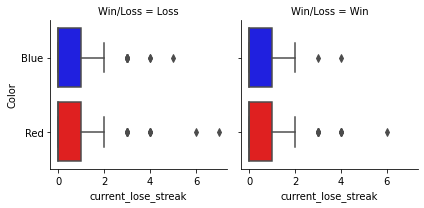

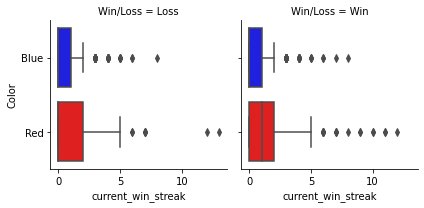

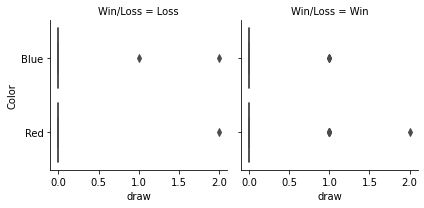

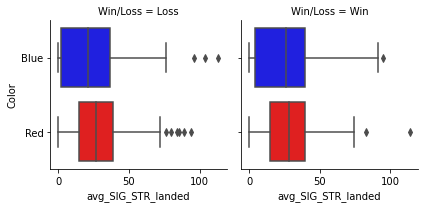

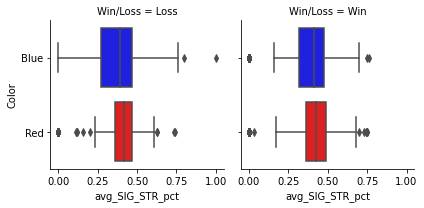

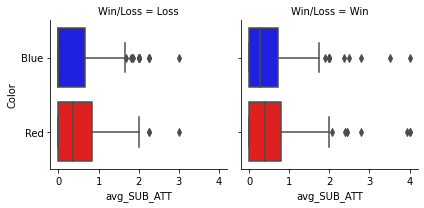

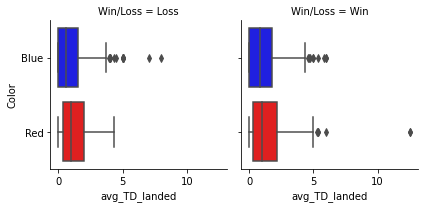

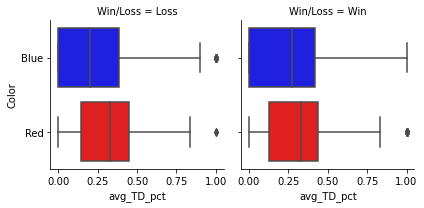

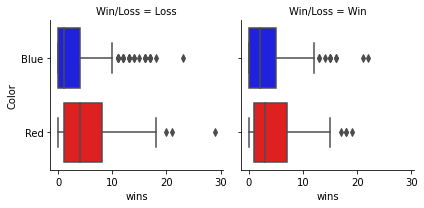

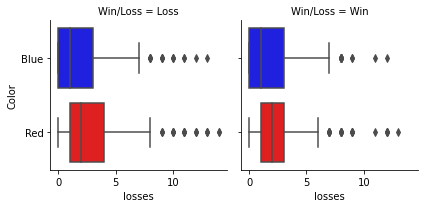

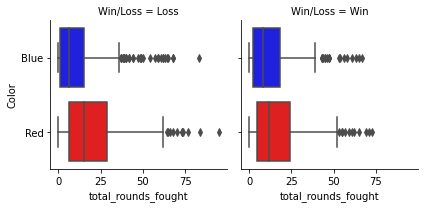

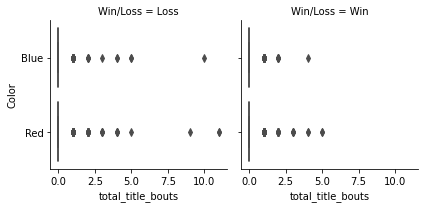

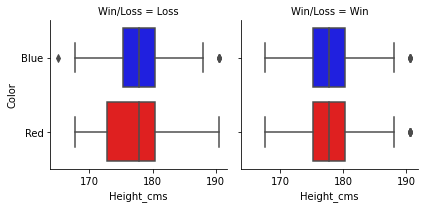

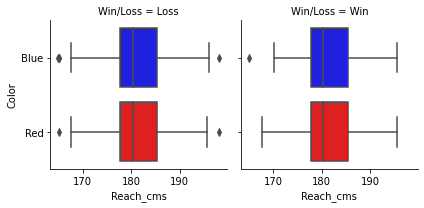

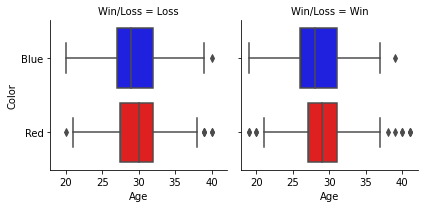

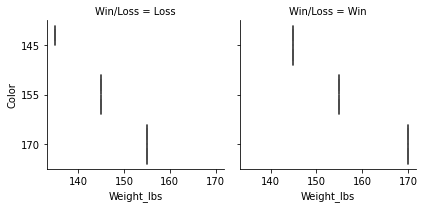

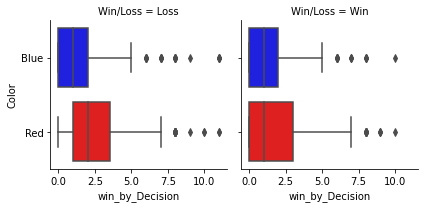

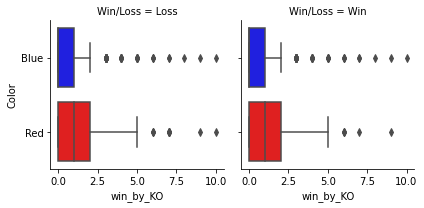

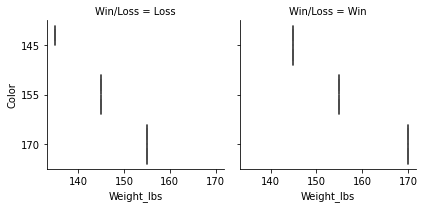

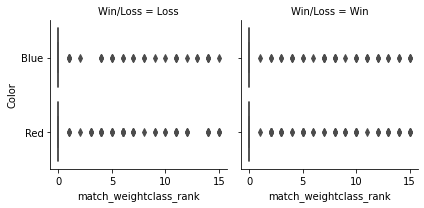

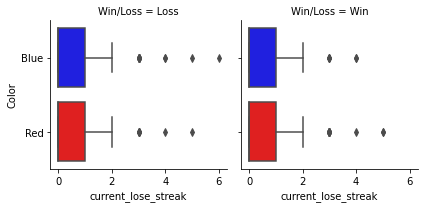

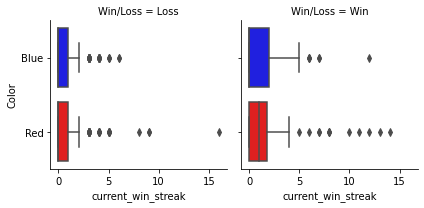

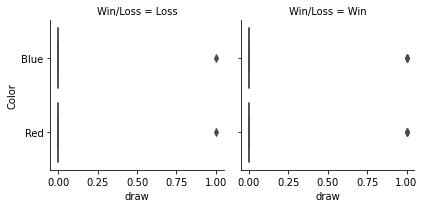

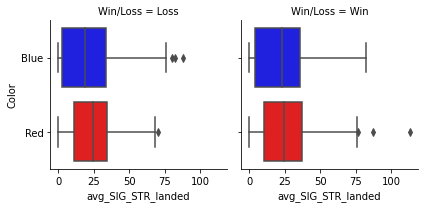

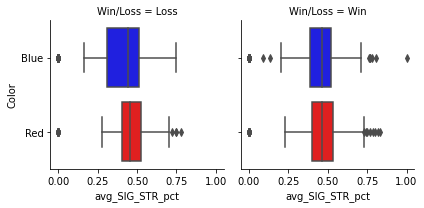

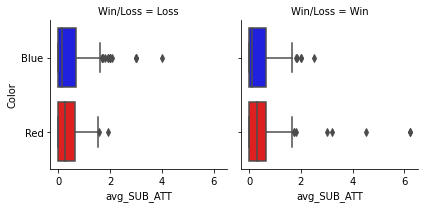

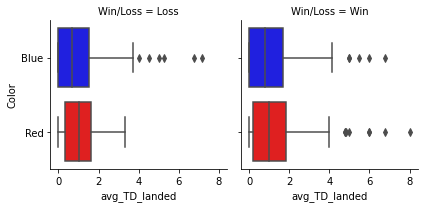

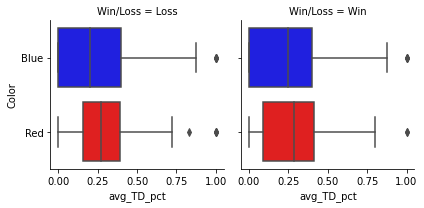

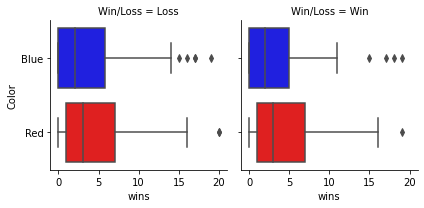

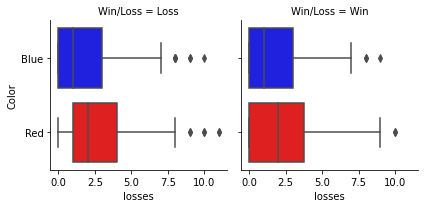

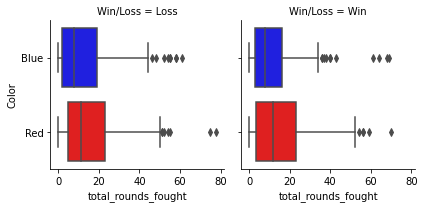

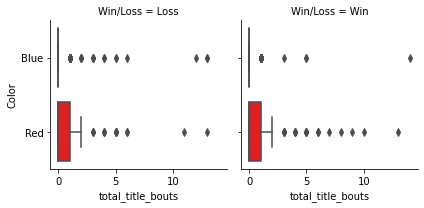

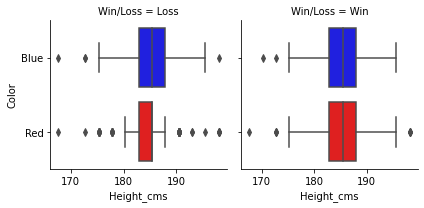

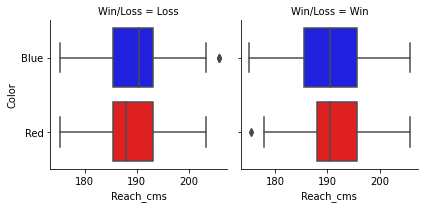

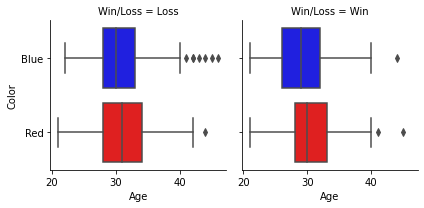

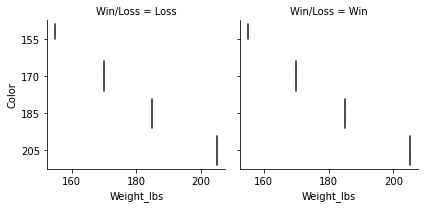

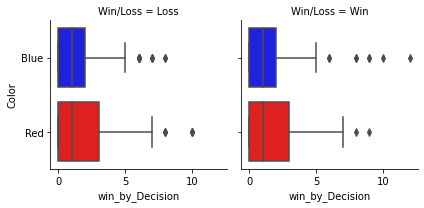

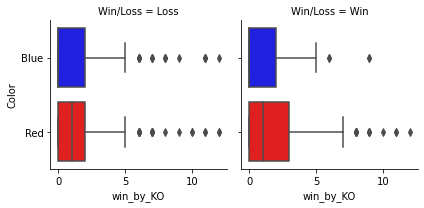

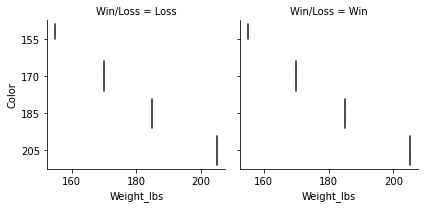

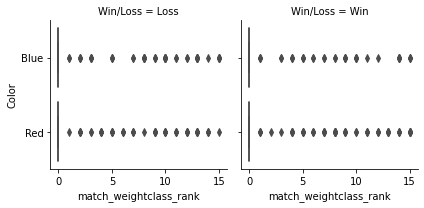

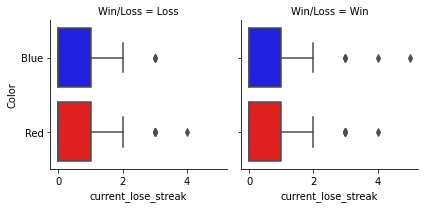

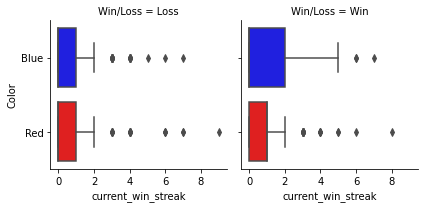

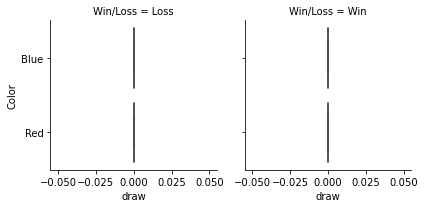

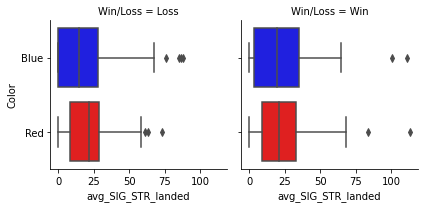

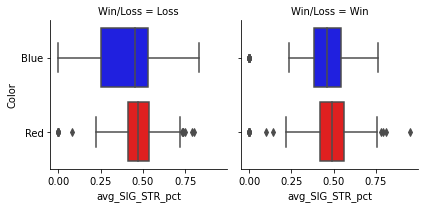

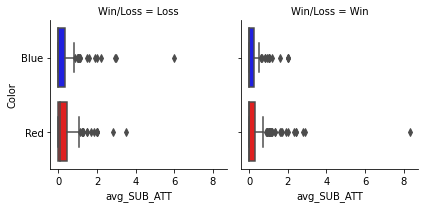

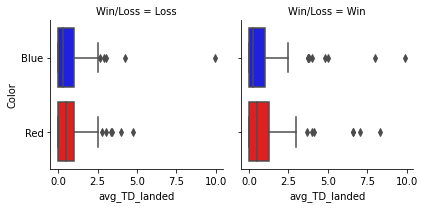

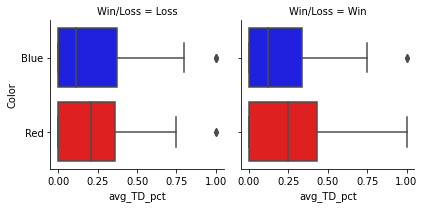

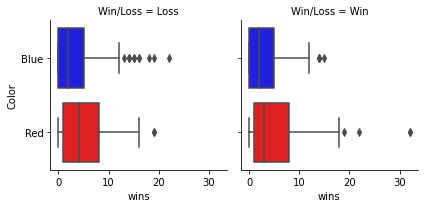

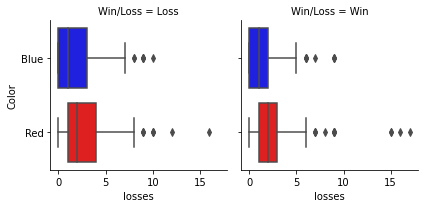

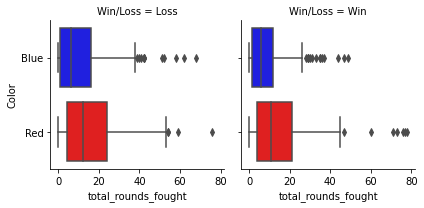

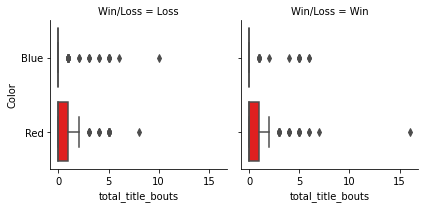

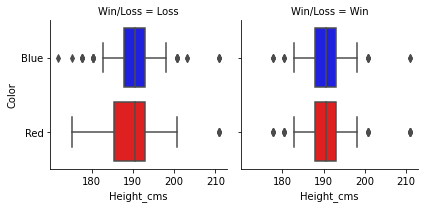

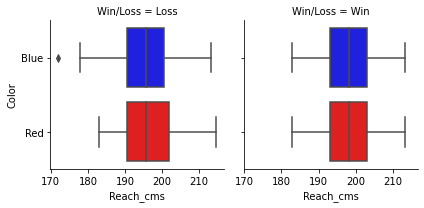

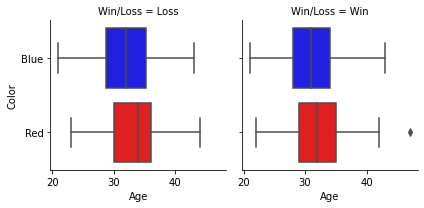

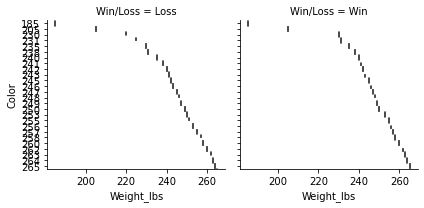

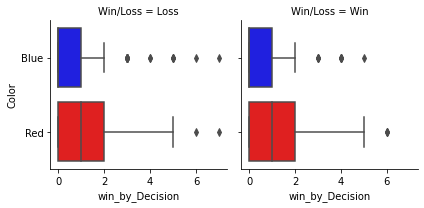

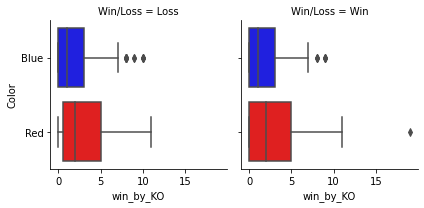

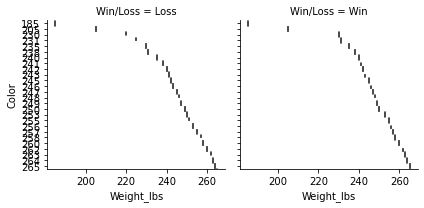

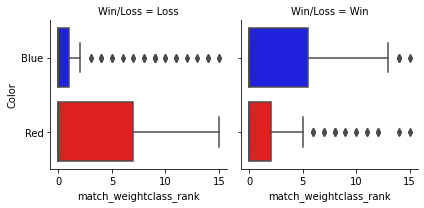

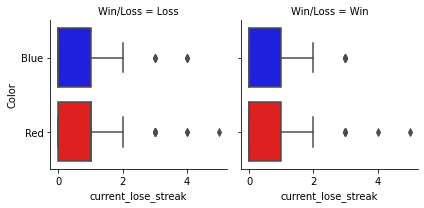

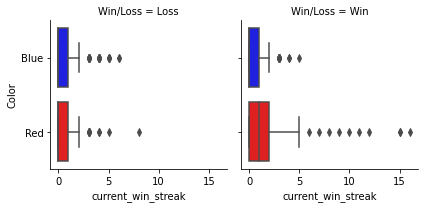

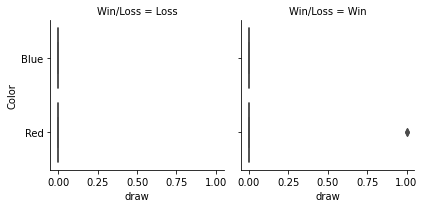

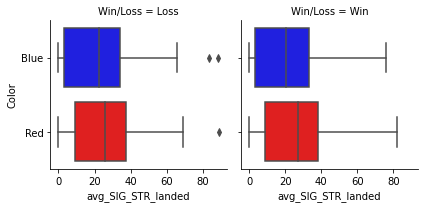

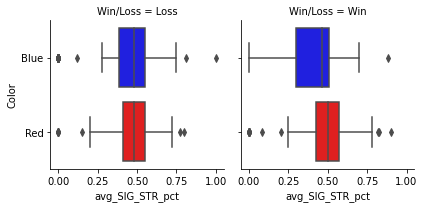

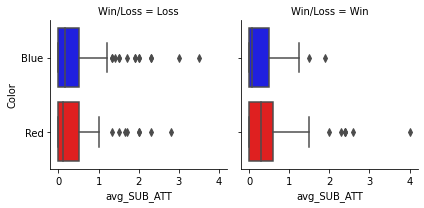

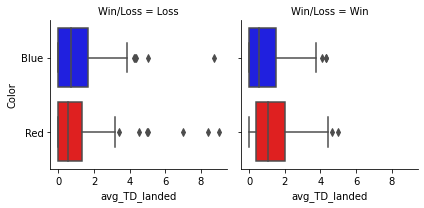

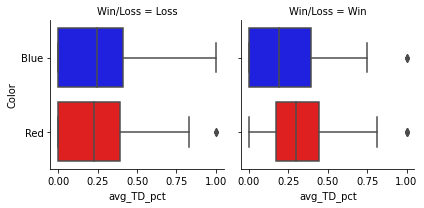

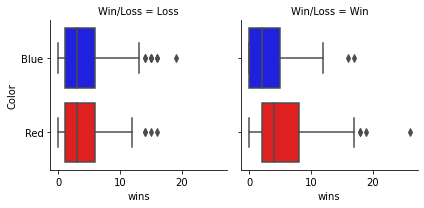

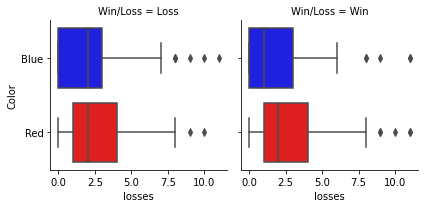

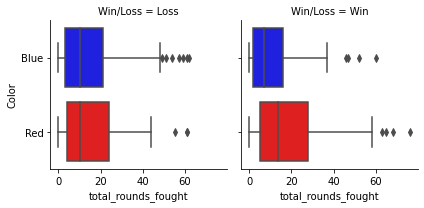

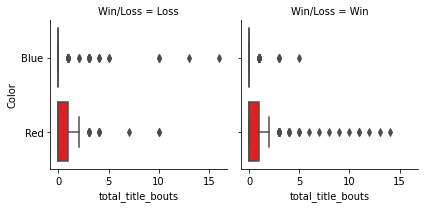

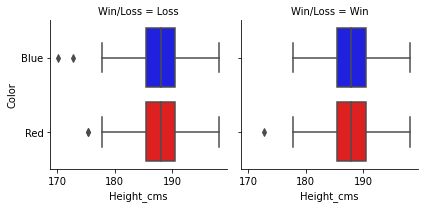

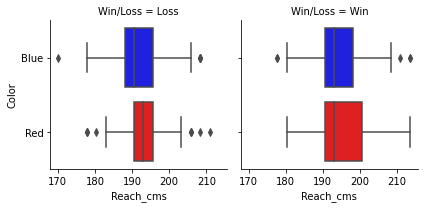

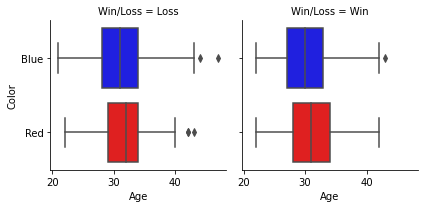

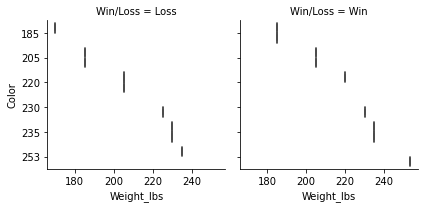

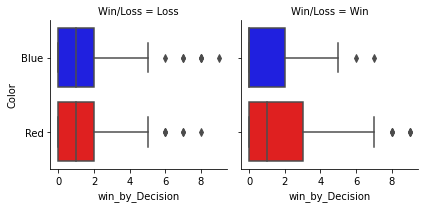

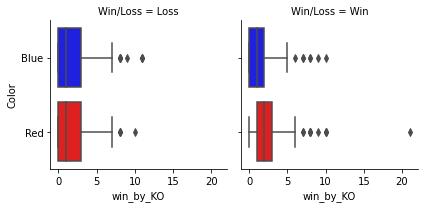

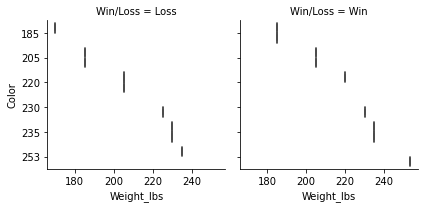

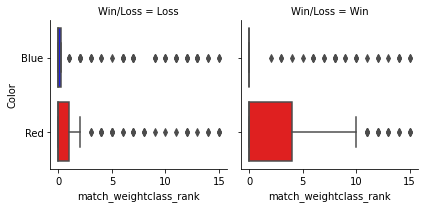

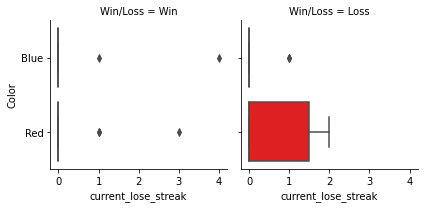

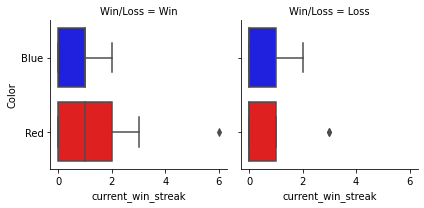

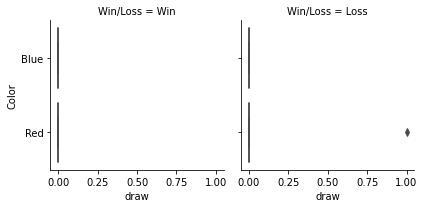

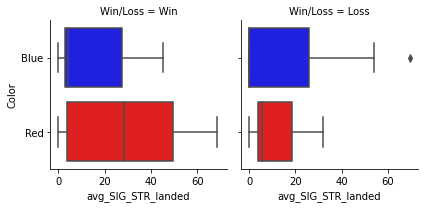

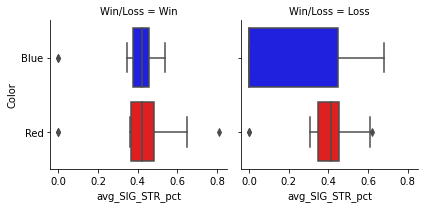

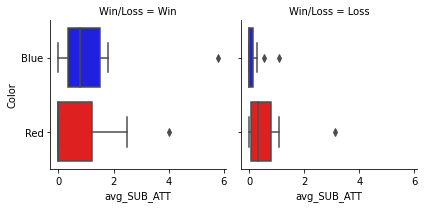

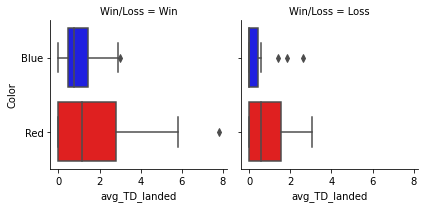

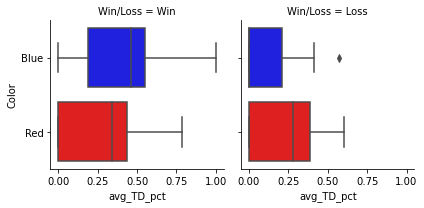

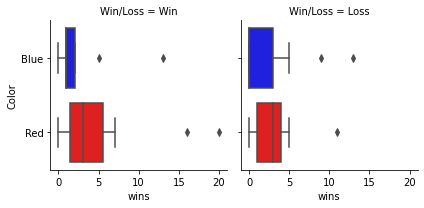

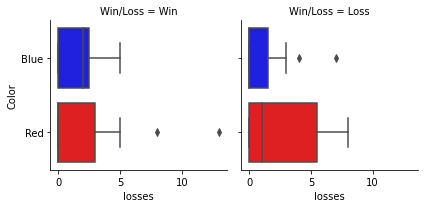

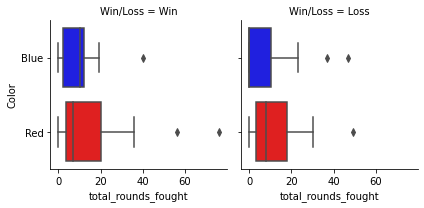

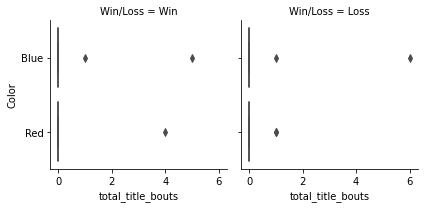

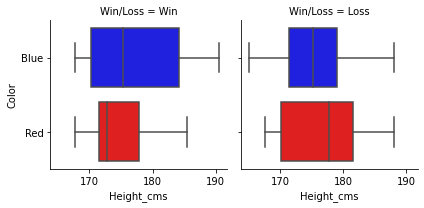

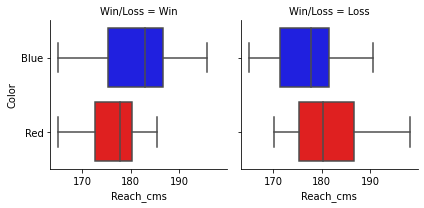

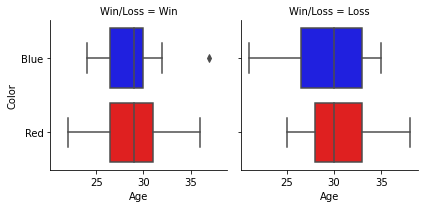

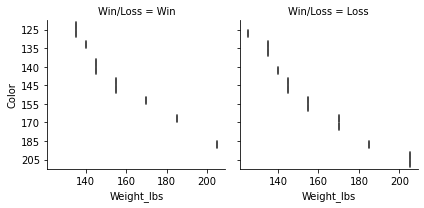

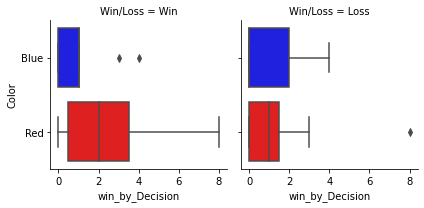

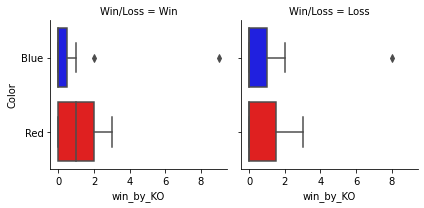

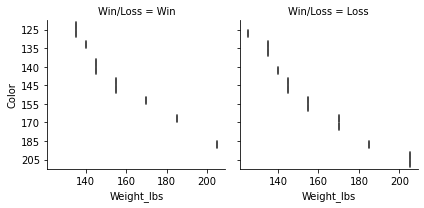

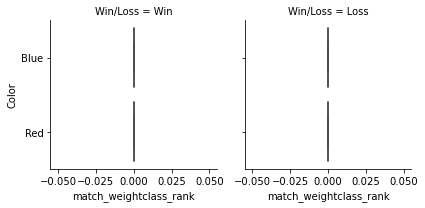

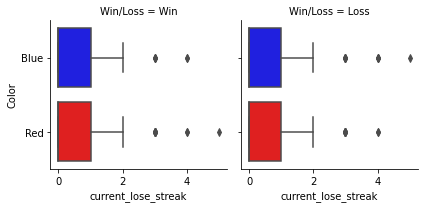

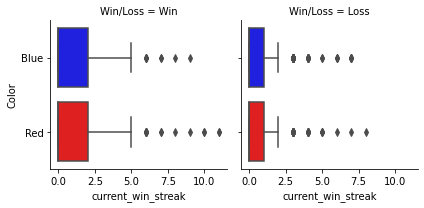

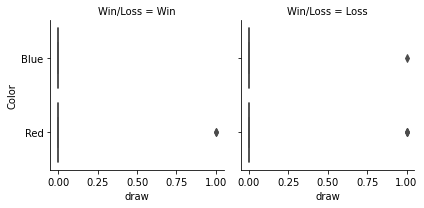

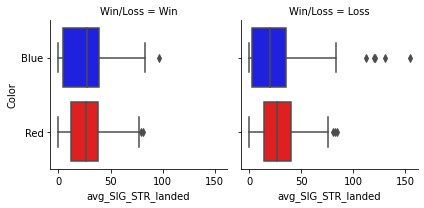

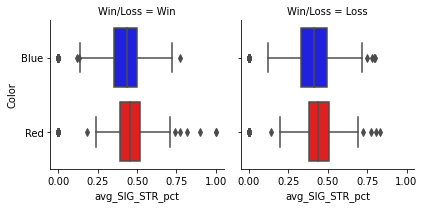

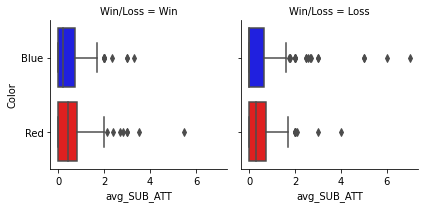

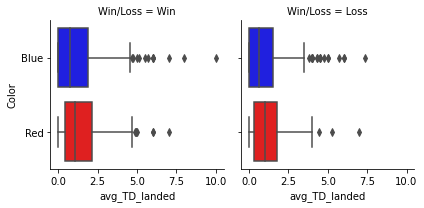

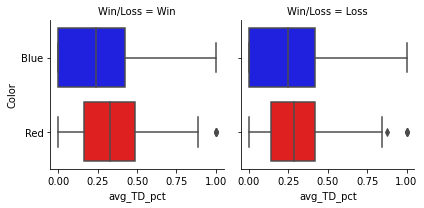

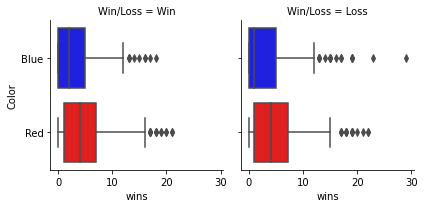

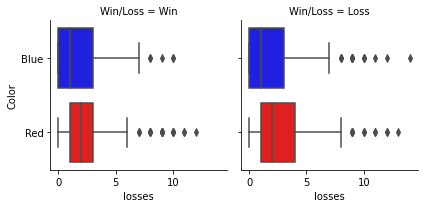

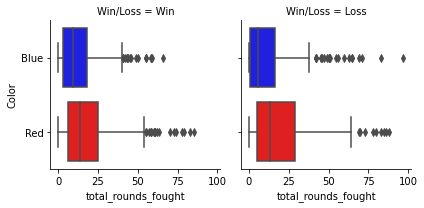

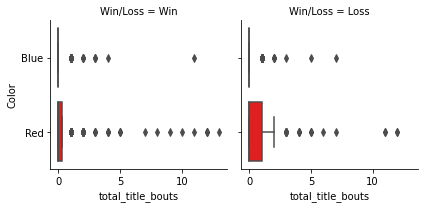

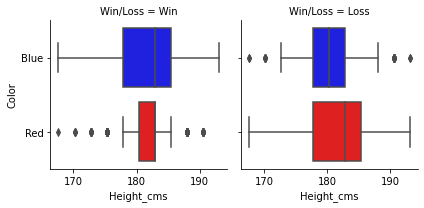

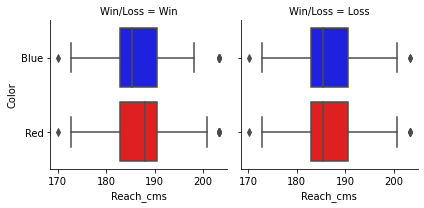

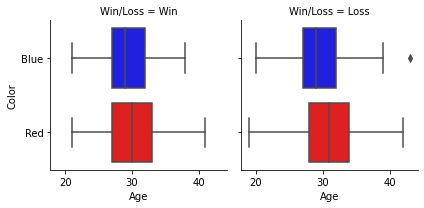

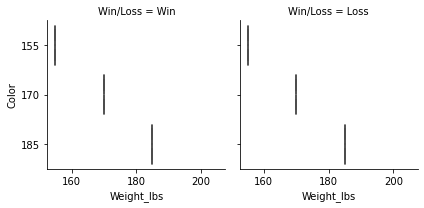

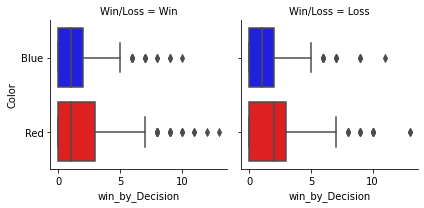

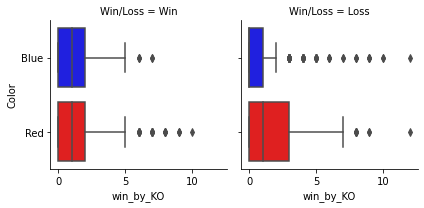

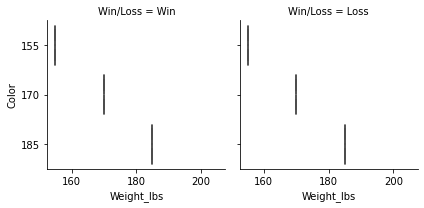

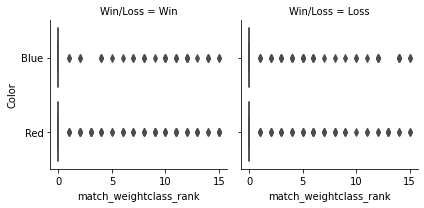

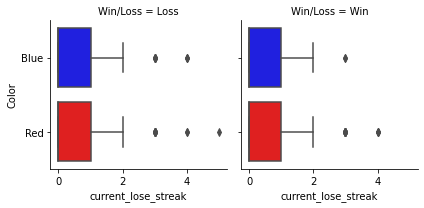

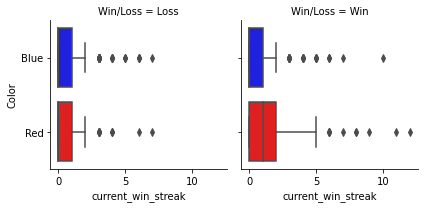

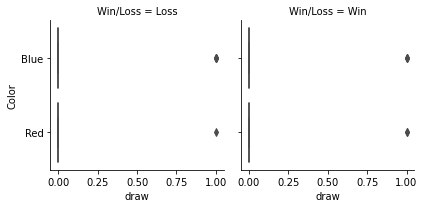

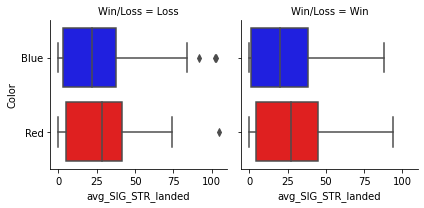

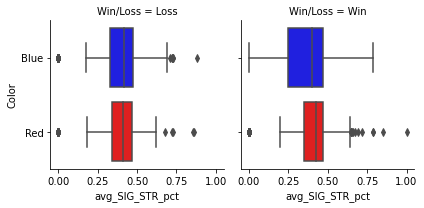

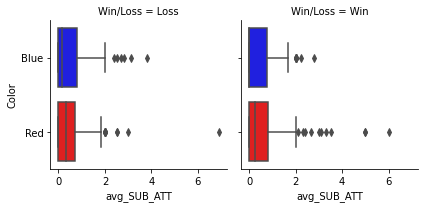

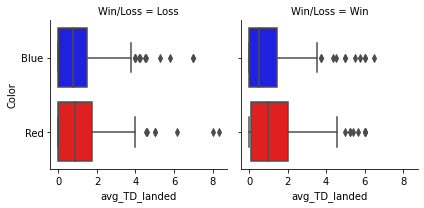

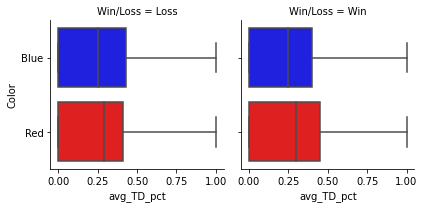

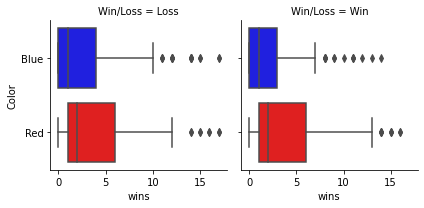

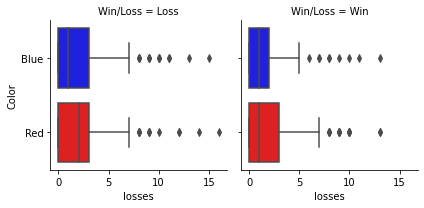

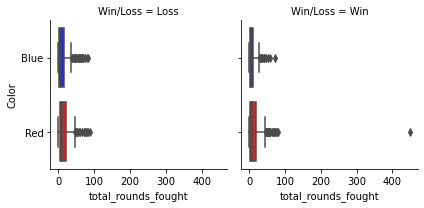

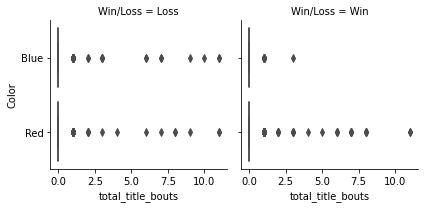

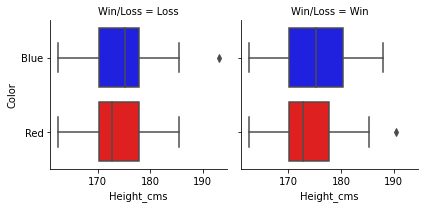

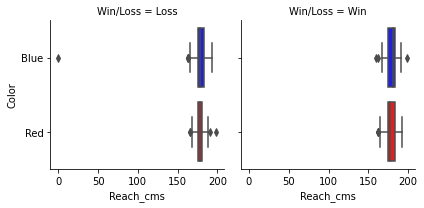

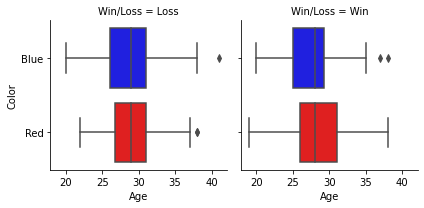

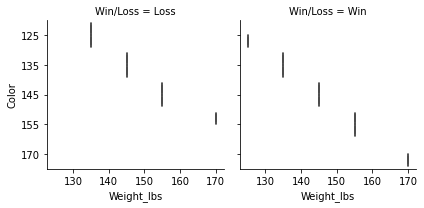

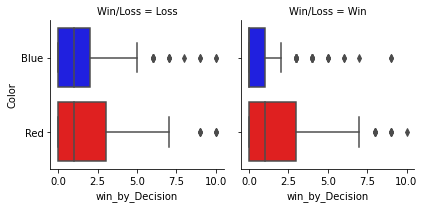

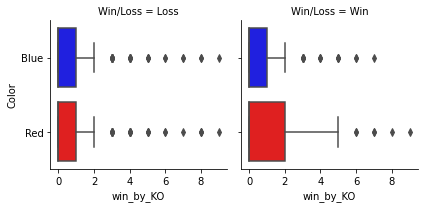

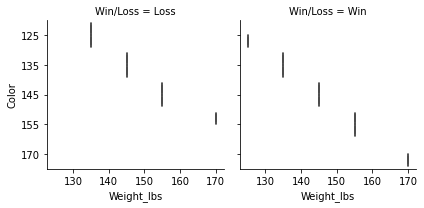

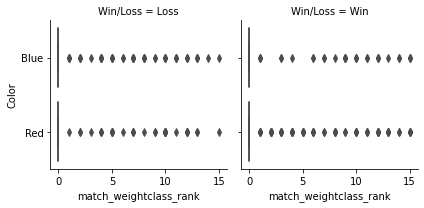

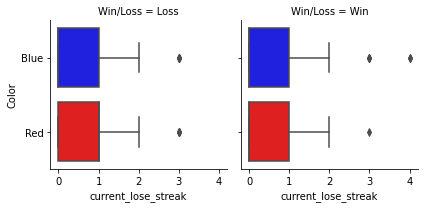

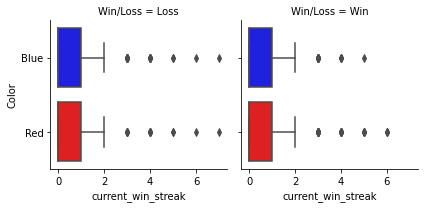

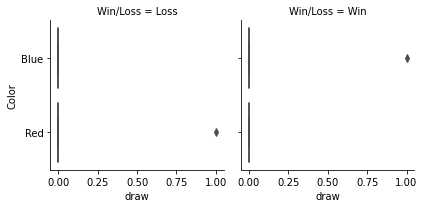

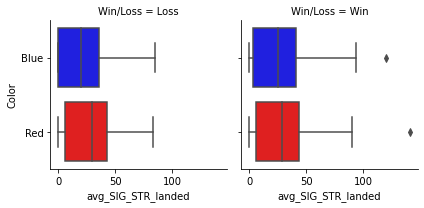

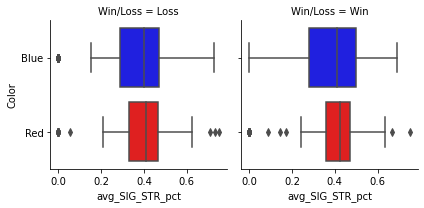

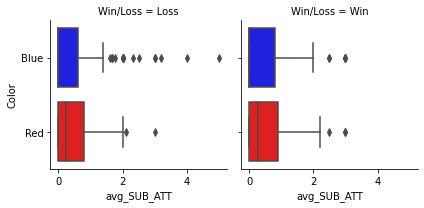

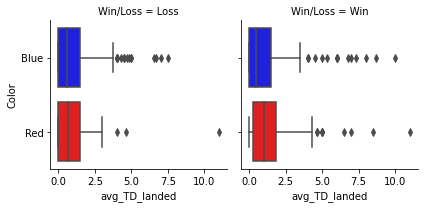

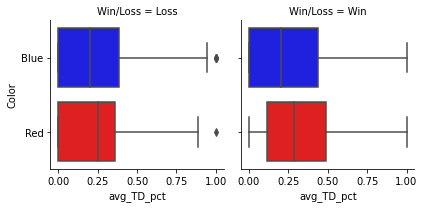

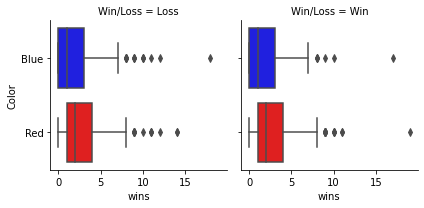

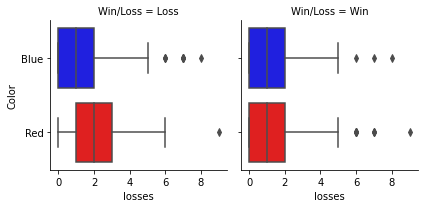

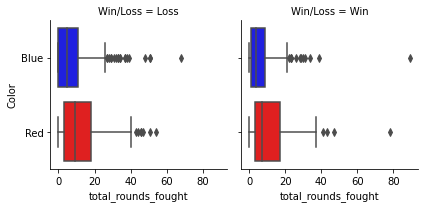

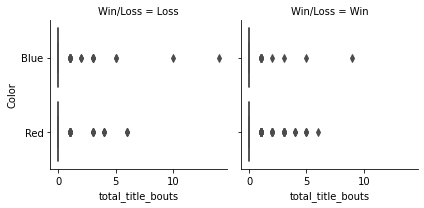

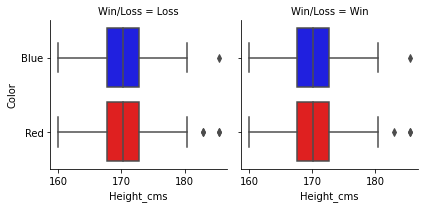

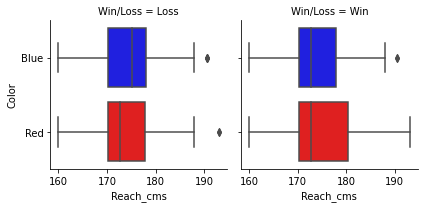

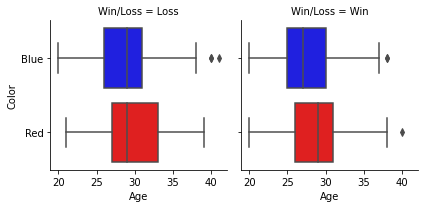

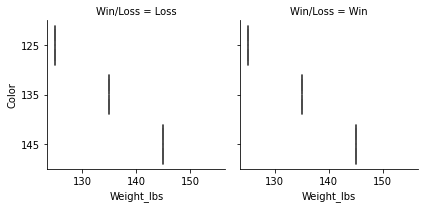

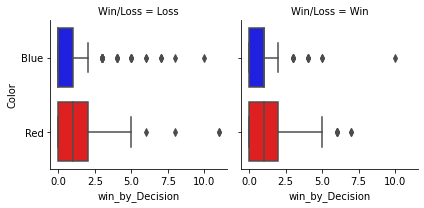

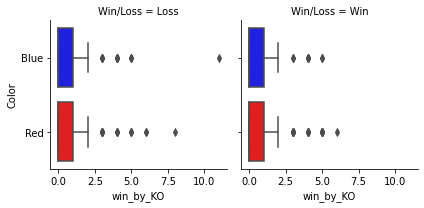

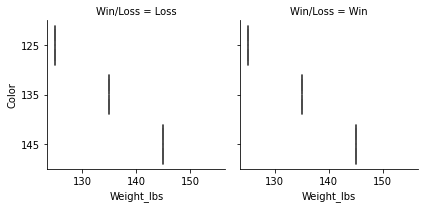

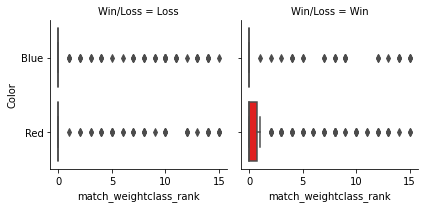

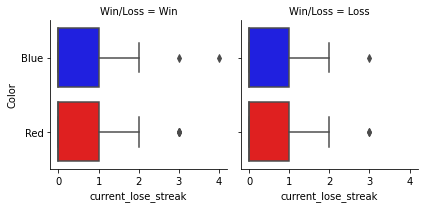

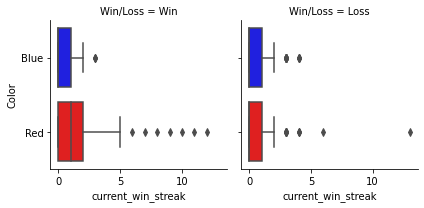

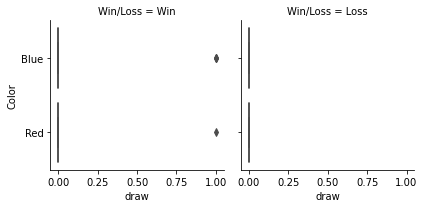

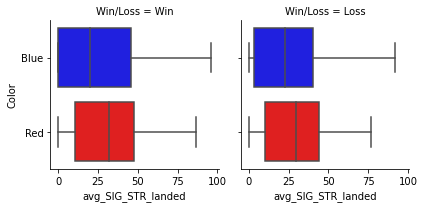

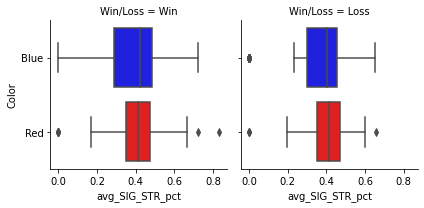

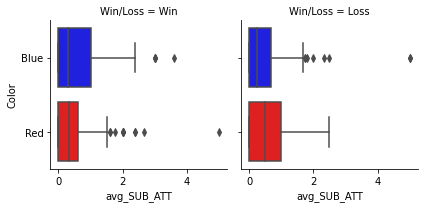

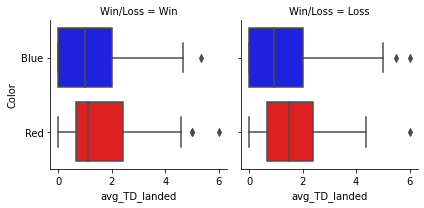

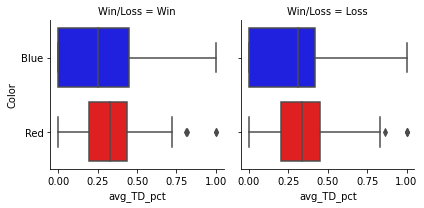

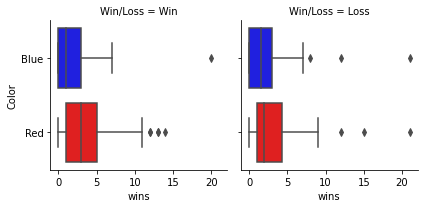

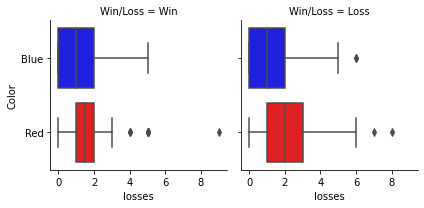

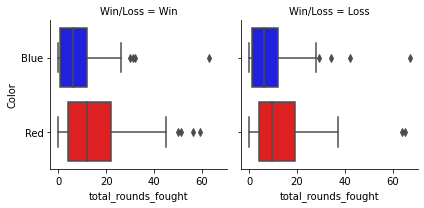

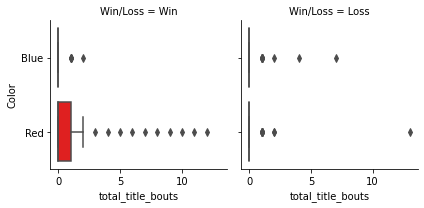

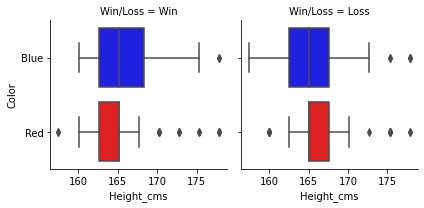

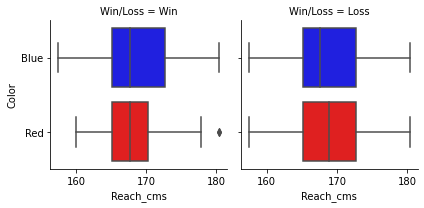

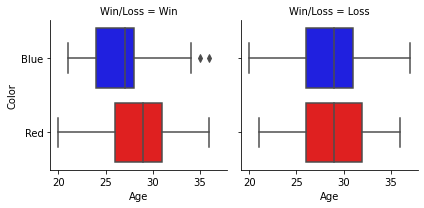

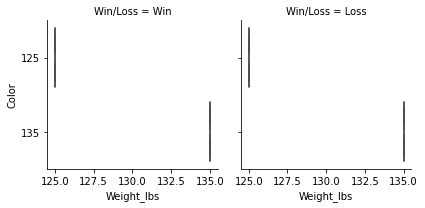

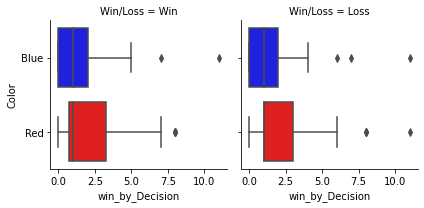

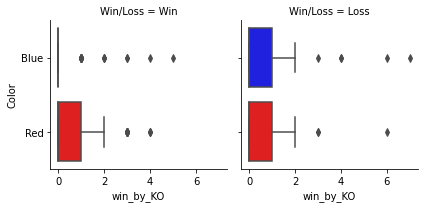

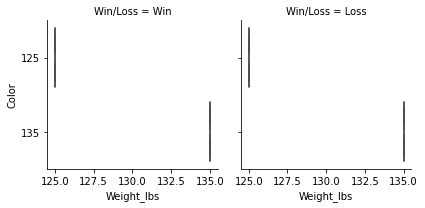

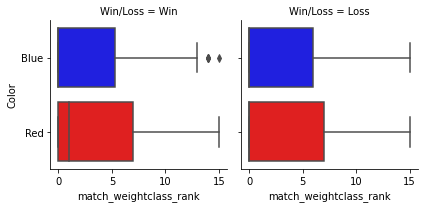

In [34]:
# Have the right order so disregarding the order warning
warnings.filterwarnings('ignore')

# All Weight classes and vars per
for wc in m_weight_class:
    subset = m_winner_f[m_winner_f['weight_class'] == wc]
    for col in fighter_columns[2:]:
        g = sns.FacetGrid(subset, col='Win/Loss')
        g.map(sns.boxplot, col,'Color',palette=['#0000FF','#ff0000'], orient='h')

[Text(0.5, 0, 'Winner'),
 Text(1.5, 0, 'current_lose_streak'),
 Text(2.5, 0, 'current_win_streak'),
 Text(3.5, 0, 'draw'),
 Text(4.5, 0, 'avg_SIG_STR_landed'),
 Text(5.5, 0, 'avg_SIG_STR_pct'),
 Text(6.5, 0, 'avg_SUB_ATT'),
 Text(7.5, 0, 'avg_TD_landed'),
 Text(8.5, 0, 'avg_TD_pct'),
 Text(9.5, 0, 'wins'),
 Text(10.5, 0, 'losses'),
 Text(11.5, 0, 'total_rounds_fought'),
 Text(12.5, 0, 'total_title_bouts'),
 Text(13.5, 0, 'Height_cms'),
 Text(14.5, 0, 'Reach_cms'),
 Text(15.5, 0, 'Age'),
 Text(16.5, 0, 'Weight_lbs'),
 Text(17.5, 0, 'win_by_Decision'),
 Text(18.5, 0, 'win_by_KO'),
 Text(19.5, 0, 'Weight_lbs'),
 Text(20.5, 0, 'match_weightclass_rank')]

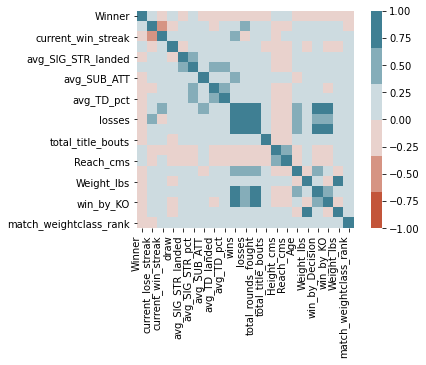

In [35]:
# Looking at relationship or variables: Lightweight Weight Class

m_lw = m_winner_f[m_winner_f['weight_class'] == 'Lightweight']
corr = m_lw.corr()
ax = sns.heatmap(
corr,
vmin=-1, vmax=1, center =0,
cmap=sns.diverging_palette(20,220),
square=True)
ax.set_xticklabels(
ax.get_xticklabels(),
rotation=90,
horizontalalignment='right')

[Text(0.5, 0, 'Winner'),
 Text(1.5, 0, 'current_lose_streak'),
 Text(2.5, 0, 'current_win_streak'),
 Text(3.5, 0, 'draw'),
 Text(4.5, 0, 'avg_SIG_STR_landed'),
 Text(5.5, 0, 'avg_SIG_STR_pct'),
 Text(6.5, 0, 'avg_SUB_ATT'),
 Text(7.5, 0, 'avg_TD_landed'),
 Text(8.5, 0, 'avg_TD_pct'),
 Text(9.5, 0, 'wins'),
 Text(10.5, 0, 'losses'),
 Text(11.5, 0, 'total_rounds_fought'),
 Text(12.5, 0, 'total_title_bouts'),
 Text(13.5, 0, 'Height_cms'),
 Text(14.5, 0, 'Reach_cms'),
 Text(15.5, 0, 'Age'),
 Text(16.5, 0, 'Weight_lbs'),
 Text(17.5, 0, 'win_by_Decision'),
 Text(18.5, 0, 'win_by_KO'),
 Text(19.5, 0, 'Weight_lbs'),
 Text(20.5, 0, 'match_weightclass_rank')]

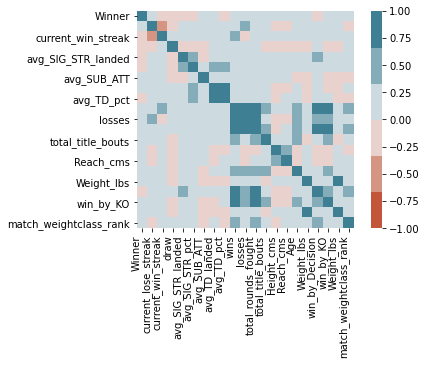

In [36]:
# Looking at relationship or variables: Middleweight Weight Class

m_mw = m_winner_f[m_winner_f['weight_class'] == 'Middleweight']
corr = m_mw.corr()
ax = sns.heatmap(
corr,
vmin=-1, vmax=1, center =0,
cmap=sns.diverging_palette(20,220),
square=True)
ax.set_xticklabels(
ax.get_xticklabels(),
rotation=90,
horizontalalignment='right')

[Text(0.5, 0, 'Winner'),
 Text(1.5, 0, 'current_lose_streak'),
 Text(2.5, 0, 'current_win_streak'),
 Text(3.5, 0, 'draw'),
 Text(4.5, 0, 'avg_SIG_STR_landed'),
 Text(5.5, 0, 'avg_SIG_STR_pct'),
 Text(6.5, 0, 'avg_SUB_ATT'),
 Text(7.5, 0, 'avg_TD_landed'),
 Text(8.5, 0, 'avg_TD_pct'),
 Text(9.5, 0, 'wins'),
 Text(10.5, 0, 'losses'),
 Text(11.5, 0, 'total_rounds_fought'),
 Text(12.5, 0, 'total_title_bouts'),
 Text(13.5, 0, 'Height_cms'),
 Text(14.5, 0, 'Reach_cms'),
 Text(15.5, 0, 'Age'),
 Text(16.5, 0, 'Weight_lbs'),
 Text(17.5, 0, 'win_by_Decision'),
 Text(18.5, 0, 'win_by_KO'),
 Text(19.5, 0, 'Weight_lbs'),
 Text(20.5, 0, 'match_weightclass_rank')]

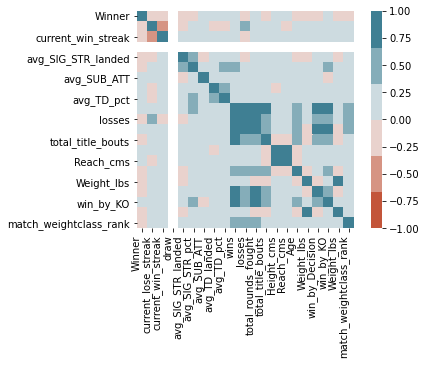

In [37]:
# Looking at relationship or variables: Heavyweight Weight Class

m_hw = m_winner_f[m_winner_f['weight_class'] == 'Heavyweight']
corr = m_hw.corr()
ax = sns.heatmap(
corr,
vmin=-1, vmax=1, center =0,
cmap=sns.diverging_palette(20,220),
square=True)
ax.set_xticklabels(
ax.get_xticklabels(),
rotation=90,
horizontalalignment='right')

[Text(0.5, 0, 'Winner'),
 Text(1.5, 0, 'current_lose_streak'),
 Text(2.5, 0, 'current_win_streak'),
 Text(3.5, 0, 'draw'),
 Text(4.5, 0, 'avg_SIG_STR_landed'),
 Text(5.5, 0, 'avg_SIG_STR_pct'),
 Text(6.5, 0, 'avg_SUB_ATT'),
 Text(7.5, 0, 'avg_TD_landed'),
 Text(8.5, 0, 'avg_TD_pct'),
 Text(9.5, 0, 'wins'),
 Text(10.5, 0, 'losses'),
 Text(11.5, 0, 'total_rounds_fought'),
 Text(12.5, 0, 'total_title_bouts'),
 Text(13.5, 0, 'Height_cms'),
 Text(14.5, 0, 'Reach_cms'),
 Text(15.5, 0, 'Age'),
 Text(16.5, 0, 'Weight_lbs'),
 Text(17.5, 0, 'win_by_Decision'),
 Text(18.5, 0, 'win_by_KO'),
 Text(19.5, 0, 'Weight_lbs'),
 Text(20.5, 0, 'match_weightclass_rank')]

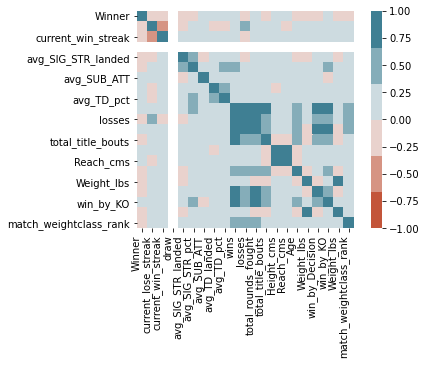

In [38]:
# Looking at relationship or variables: Heavyweight Weight Class

m_hw = m_winner_f[m_winner_f['weight_class'] == 'Heavyweight']
corr = m_hw.corr()
ax = sns.heatmap(
corr,
vmin=-1, vmax=1, center =0,
cmap=sns.diverging_palette(20,220),
square=True)
ax.set_xticklabels(
ax.get_xticklabels(),
rotation=90,
horizontalalignment='right')

[Text(0.5, 0, 'Winner'),
 Text(1.5, 0, 'current_lose_streak'),
 Text(2.5, 0, 'current_win_streak'),
 Text(3.5, 0, 'draw'),
 Text(4.5, 0, 'avg_SIG_STR_landed'),
 Text(5.5, 0, 'avg_SIG_STR_pct'),
 Text(6.5, 0, 'avg_SUB_ATT'),
 Text(7.5, 0, 'avg_TD_landed'),
 Text(8.5, 0, 'avg_TD_pct'),
 Text(9.5, 0, 'wins'),
 Text(10.5, 0, 'losses'),
 Text(11.5, 0, 'total_rounds_fought'),
 Text(12.5, 0, 'total_title_bouts'),
 Text(13.5, 0, 'Height_cms'),
 Text(14.5, 0, 'Reach_cms'),
 Text(15.5, 0, 'Age'),
 Text(16.5, 0, 'Weight_lbs'),
 Text(17.5, 0, 'win_by_Decision'),
 Text(18.5, 0, 'win_by_KO'),
 Text(19.5, 0, 'Weight_lbs'),
 Text(20.5, 0, 'match_weightclass_rank')]

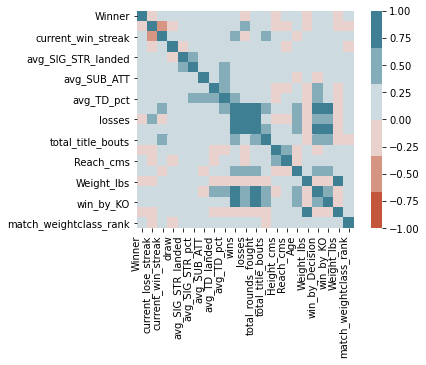

In [39]:
# Looking at relationship or variables: Light Heavyweight Weight Class

m_lhw = m_winner_f[m_winner_f['weight_class'] == 'Light Heavyweight']
corr = m_lhw.corr()
ax = sns.heatmap(
corr,
vmin=-1, vmax=1, center =0,
cmap=sns.diverging_palette(20,220),
square=True)
ax.set_xticklabels(
ax.get_xticklabels(),
rotation=90,
horizontalalignment='right')

[Text(0.5, 0, 'Winner'),
 Text(1.5, 0, 'current_lose_streak'),
 Text(2.5, 0, 'current_win_streak'),
 Text(3.5, 0, 'draw'),
 Text(4.5, 0, 'avg_SIG_STR_landed'),
 Text(5.5, 0, 'avg_SIG_STR_pct'),
 Text(6.5, 0, 'avg_SUB_ATT'),
 Text(7.5, 0, 'avg_TD_landed'),
 Text(8.5, 0, 'avg_TD_pct'),
 Text(9.5, 0, 'wins'),
 Text(10.5, 0, 'losses'),
 Text(11.5, 0, 'total_rounds_fought'),
 Text(12.5, 0, 'total_title_bouts'),
 Text(13.5, 0, 'Height_cms'),
 Text(14.5, 0, 'Reach_cms'),
 Text(15.5, 0, 'Age'),
 Text(16.5, 0, 'Weight_lbs'),
 Text(17.5, 0, 'win_by_Decision'),
 Text(18.5, 0, 'win_by_KO'),
 Text(19.5, 0, 'Weight_lbs'),
 Text(20.5, 0, 'match_weightclass_rank')]

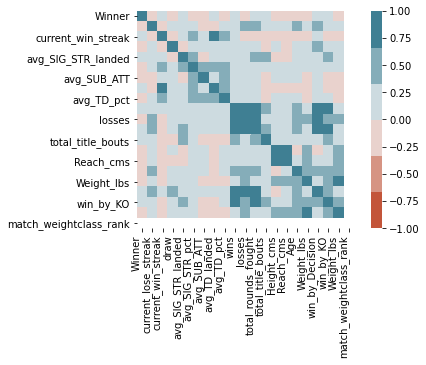

In [40]:
# Looking at relationship or variables: Catch Weight Weight Class

m_cw = m_winner_f[m_winner_f['weight_class'] == 'Catch Weight']
corr = m_cw.corr()
ax = sns.heatmap(
corr,
vmin=-1, vmax=1, center =0,
cmap=sns.diverging_palette(20,220),
square=True)
ax.set_xticklabels(
ax.get_xticklabels(),
rotation=90,
horizontalalignment='right')

[Text(0.5, 0, 'Winner'),
 Text(1.5, 0, 'current_lose_streak'),
 Text(2.5, 0, 'current_win_streak'),
 Text(3.5, 0, 'draw'),
 Text(4.5, 0, 'avg_SIG_STR_landed'),
 Text(5.5, 0, 'avg_SIG_STR_pct'),
 Text(6.5, 0, 'avg_SUB_ATT'),
 Text(7.5, 0, 'avg_TD_landed'),
 Text(8.5, 0, 'avg_TD_pct'),
 Text(9.5, 0, 'wins'),
 Text(10.5, 0, 'losses'),
 Text(11.5, 0, 'total_rounds_fought'),
 Text(12.5, 0, 'total_title_bouts'),
 Text(13.5, 0, 'Height_cms'),
 Text(14.5, 0, 'Reach_cms'),
 Text(15.5, 0, 'Age'),
 Text(16.5, 0, 'Weight_lbs'),
 Text(17.5, 0, 'win_by_Decision'),
 Text(18.5, 0, 'win_by_KO'),
 Text(19.5, 0, 'Weight_lbs'),
 Text(20.5, 0, 'match_weightclass_rank')]

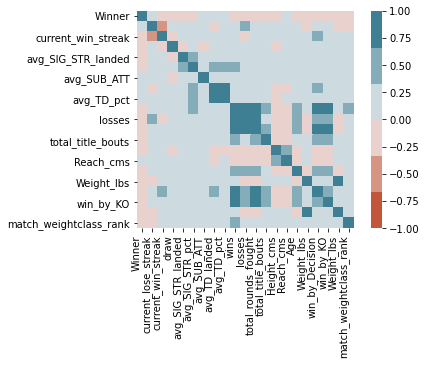

In [41]:
# Looking at relationship or variables: Welterweight Weight Class

m_ww = m_winner_f[m_winner_f['weight_class'] == 'Welterweight']
corr = m_ww.corr()
ax = sns.heatmap(
corr,
vmin=-1, vmax=1, center =0,
cmap=sns.diverging_palette(20,220),
square=True)
ax.set_xticklabels(
ax.get_xticklabels(),
rotation=90,
horizontalalignment='right')

[Text(0.5, 0, 'Winner'),
 Text(1.5, 0, 'current_lose_streak'),
 Text(2.5, 0, 'current_win_streak'),
 Text(3.5, 0, 'draw'),
 Text(4.5, 0, 'avg_SIG_STR_landed'),
 Text(5.5, 0, 'avg_SIG_STR_pct'),
 Text(6.5, 0, 'avg_SUB_ATT'),
 Text(7.5, 0, 'avg_TD_landed'),
 Text(8.5, 0, 'avg_TD_pct'),
 Text(9.5, 0, 'wins'),
 Text(10.5, 0, 'losses'),
 Text(11.5, 0, 'total_rounds_fought'),
 Text(12.5, 0, 'total_title_bouts'),
 Text(13.5, 0, 'Height_cms'),
 Text(14.5, 0, 'Reach_cms'),
 Text(15.5, 0, 'Age'),
 Text(16.5, 0, 'Weight_lbs'),
 Text(17.5, 0, 'win_by_Decision'),
 Text(18.5, 0, 'win_by_KO'),
 Text(19.5, 0, 'Weight_lbs'),
 Text(20.5, 0, 'match_weightclass_rank')]

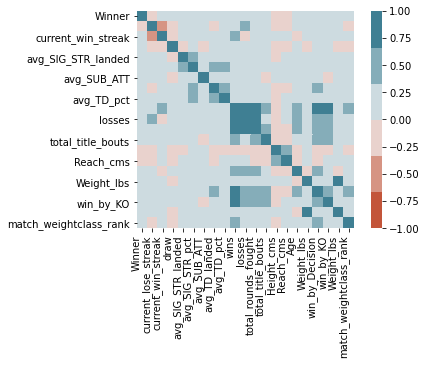

In [42]:
# Looking at relationship or variables: Featherweight Weight Class

m_fw = m_winner_f[m_winner_f['weight_class'] == 'Featherweight']
corr = m_fw.corr()
ax = sns.heatmap(
corr,
vmin=-1, vmax=1, center =0,
cmap=sns.diverging_palette(20,220),
square=True)
ax.set_xticklabels(
ax.get_xticklabels(),
rotation=90,
horizontalalignment='right')

[Text(0.5, 0, 'Winner'),
 Text(1.5, 0, 'current_lose_streak'),
 Text(2.5, 0, 'current_win_streak'),
 Text(3.5, 0, 'draw'),
 Text(4.5, 0, 'avg_SIG_STR_landed'),
 Text(5.5, 0, 'avg_SIG_STR_pct'),
 Text(6.5, 0, 'avg_SUB_ATT'),
 Text(7.5, 0, 'avg_TD_landed'),
 Text(8.5, 0, 'avg_TD_pct'),
 Text(9.5, 0, 'wins'),
 Text(10.5, 0, 'losses'),
 Text(11.5, 0, 'total_rounds_fought'),
 Text(12.5, 0, 'total_title_bouts'),
 Text(13.5, 0, 'Height_cms'),
 Text(14.5, 0, 'Reach_cms'),
 Text(15.5, 0, 'Age'),
 Text(16.5, 0, 'Weight_lbs'),
 Text(17.5, 0, 'win_by_Decision'),
 Text(18.5, 0, 'win_by_KO'),
 Text(19.5, 0, 'Weight_lbs'),
 Text(20.5, 0, 'match_weightclass_rank')]

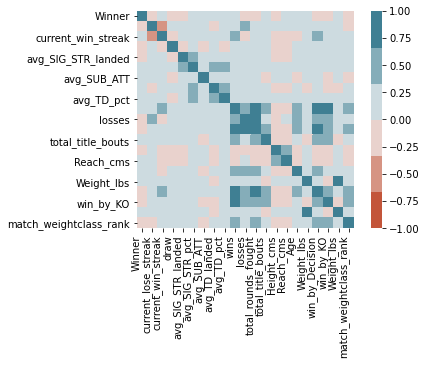

In [43]:
# Looking at relationship or variables: Bantamweight Weight Class

m_bw = m_winner_f[m_winner_f['weight_class'] == 'Bantamweight']
corr = m_bw.corr()
ax = sns.heatmap(
corr,
vmin=-1, vmax=1, center =0,
cmap=sns.diverging_palette(20,220),
square=True)
ax.set_xticklabels(
ax.get_xticklabels(),
rotation=90,
horizontalalignment='right')

[Text(0.5, 0, 'Winner'),
 Text(1.5, 0, 'current_lose_streak'),
 Text(2.5, 0, 'current_win_streak'),
 Text(3.5, 0, 'draw'),
 Text(4.5, 0, 'avg_SIG_STR_landed'),
 Text(5.5, 0, 'avg_SIG_STR_pct'),
 Text(6.5, 0, 'avg_SUB_ATT'),
 Text(7.5, 0, 'avg_TD_landed'),
 Text(8.5, 0, 'avg_TD_pct'),
 Text(9.5, 0, 'wins'),
 Text(10.5, 0, 'losses'),
 Text(11.5, 0, 'total_rounds_fought'),
 Text(12.5, 0, 'total_title_bouts'),
 Text(13.5, 0, 'Height_cms'),
 Text(14.5, 0, 'Reach_cms'),
 Text(15.5, 0, 'Age'),
 Text(16.5, 0, 'Weight_lbs'),
 Text(17.5, 0, 'win_by_Decision'),
 Text(18.5, 0, 'win_by_KO'),
 Text(19.5, 0, 'Weight_lbs'),
 Text(20.5, 0, 'match_weightclass_rank')]

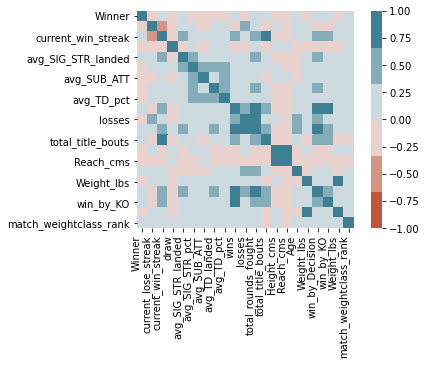

In [44]:
# Looking at relationship or variables: Fly Weight Class

m_fly = m_winner_f[m_winner_f['weight_class'] == 'Flyweight']
corr = m_fly.corr()
ax = sns.heatmap(
corr,
vmin=-1, vmax=1, center =0,
cmap=sns.diverging_palette(20,220),
square=True)
ax.set_xticklabels(
ax.get_xticklabels(),
rotation=90,
horizontalalignment='right')

In [45]:
# Gets the feature set of a data set
def get_winner_features(data):
    m_winner_features = data.drop(['Winner'], axis = 1)
    return m_winner_features

In [46]:
# Gets the yhat set of a data set
def get_winner_yhat(data):
    m_winner_yhat = data[['Winner','weight_class']]
    return m_winner_yhat

### Decision Trees:

In [47]:
def get_dt_pm(data):
    depth = 10

    # Performance Metrics for base:
    dt_pm = pd.DataFrame(columns=['Weight_Class','Model','Model_Iteration_#','Accuracy','Precision_Score','Recall_Score (TPR)','Specificity (TNR)','F1_Score','Avg_Precision_Score','Log_Loss','TN','FP','FN','TP'],index=range((depth-1)*len(m_weight_class)))
    dt_pm['Model'] = 'DT'
    
    #Lists to gather info
    wc_pm = []
    mi_pm = []
    acc_pm = []
    pre_pm = []
    re_pm = []
    spe_pm = []
    f1_pm = []
    
    # Confusion Matrix Lists
    tn_l = []
    fp_l = []
    fn_l = []
    tp_l = []
    
    # Average Precision Score
    # Comparable to PR AUC
    avg_pr_l = []
    
    # Breaking down each weight class into its own model
    for wc in m_weight_class:

        # Get subsets:
        features_sub = get_winner_features(data)
        yhat_sub = get_winner_yhat(data)
        
        # Break down per weight class: 
        features_sub = features_sub[features_sub['weight_class'] == wc]
        yhat_sub = yhat_sub[yhat_sub['weight_class'] == wc]

        # Drop weight class, you don't need it anymore
        features_sub = features_sub.drop(['weight_class'], axis = 1)
        yhat_sub = yhat_sub.drop(['weight_class'], axis = 1)

        # Split data into training and test data
        x_train, x_test, y_train, y_test = train_test_split(features_sub, yhat_sub, test_size = .2, random_state = 32)

        # Scaling features
        x_train = preprocessing.normalize(x_train)
        x_test = preprocessing.normalize(x_test)

        # Iterating through different depths
        for d in range(1,depth):
            tree = DecisionTreeClassifier(criterion='entropy',max_depth = depth)
            tree.fit(x_train, y_train)
            tree_yhat = tree.predict(x_test)
            tree_prob = tree.predict_proba(x_test)

            wc_pm.append(wc)
            mi_pm.append(d)
            acc_pm.append(metrics.accuracy_score(y_test, tree_yhat))
            pre_pm.append(metrics.precision_score(y_test, tree_yhat))
            re_pm.append(metrics.recall_score(y_test,tree_yhat))
            f1_pm.append(f1_score(y_test,tree_yhat))
            
            # Confusion Matrix generation
            tn, fp, fn, tp = confusion_matrix(y_test, tree_yhat).ravel()
            
            # Specificity:
            spe_pm.append(tn/(tn+fp))
        
            # Storing Confusion Matrix Values
            tn_l.append(tn)
            fp_l.append(fp)
            fn_l.append(fn)
            tp_l.append(tp)
            
            # Average Precision Score
            # Comparable to PR AUC
            # predict_proba gives us values in pairs, hence the [:,1]
            avg_pr_l.append(metrics.average_precision_score(y_test, tree_prob[:,1]))


    #Store base
    dt_pm['Weight_Class'] = wc_pm
    dt_pm['Model_Iteration_#'] = mi_pm
    dt_pm['Accuracy'] = acc_pm
    dt_pm['Precision_Score'] = pre_pm
    dt_pm['Recall_Score (TPR)'] = re_pm
    dt_pm['Specificity (TNR)'] = spe_pm
    dt_pm['F1_Score'] = f1_pm
    
    # Confusion Matrix Values
    dt_pm['TN'] = tn_l
    dt_pm['FP'] = fp_l
    dt_pm['FN'] = fn_l
    dt_pm['TP'] = tp_l
    
    # ROC values
    dt_pm['Avg_Precision_Score'] = avg_pr_l
    
    return dt_pm

In [48]:
# Base dataset
base_dt_pm = get_dt_pm(m_winner_base)

In [49]:
# Best per weight classs in terms of F1_Score
idx = base_dt_pm.groupby(['Weight_Class'], sort=False)['F1_Score'].transform(max) == base_dt_pm['F1_Score']
base_dt_pm[idx].sort_values('F1_Score', ascending=False)

,Weight_Class,Model,Model_Iteration_#,Accuracy,Precision_Score,Recall_Score (TPR),Specificity (TNR),F1_Score,Avg_Precision_Score,Log_Loss,TN,FP,FN,TP
37,Catch Weight,DT,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,2,0,0,4
39,Catch Weight,DT,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,2,0,0,4
41,Catch Weight,DT,6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,2,0,0,4
44,Catch Weight,DT,9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,2,0,0,4
12,Middleweight,DT,4,0.598131,0.654321,0.779412,0.282051,0.711409,0.681300,NaN,11,28,15,53
75,Flyweight,DT,4,0.651163,0.692308,0.720000,0.555556,0.705882,0.665139,NaN,10,8,7,18
22,Heavyweight,DT,5,0.614286,0.653061,0.761905,0.392857,0.703297,0.643305,NaN,11,17,10,32
46,Welterweight,DT,2,0.580645,0.603960,0.709302,0.420290,0.652406,0.630625,NaN,29,40,25,61
53,Welterweight,DT,9,0.580645,0.603960,0.709302,0.420290,0.652406,0.630625,NaN,29,40,25,61
65,Bantamweight,DT,3,0.556818,0.708333,0.576271,0.517241,0.635514,0.707964,NaN,15,14,25,34


In [50]:
# blue-to-red dataset
b2r_dt_pm = get_dt_pm(m_winner_b2r)

In [51]:
# Best per weight classs in terms of F1_Score
idx = b2r_dt_pm.groupby(['Weight_Class'], sort=False)['F1_Score'].transform(max) == b2r_dt_pm['F1_Score']
b2r_dt_pm[idx].sort_values('F1_Score', ascending=False)

,Weight_Class,Model,Model_Iteration_#,Accuracy,Precision_Score,Recall_Score (TPR),Specificity (TNR),F1_Score,Avg_Precision_Score,Log_Loss,TN,FP,FN,TP
36,Catch Weight,DT,1,0.666667,0.750000,0.750000,0.500000,0.750000,0.729167,NaN,1,1,1,3
39,Catch Weight,DT,4,0.666667,0.750000,0.750000,0.500000,0.750000,0.729167,NaN,1,1,1,3
41,Catch Weight,DT,6,0.666667,0.750000,0.750000,0.500000,0.750000,0.729167,NaN,1,1,1,3
43,Catch Weight,DT,8,0.666667,0.750000,0.750000,0.500000,0.750000,0.729167,NaN,1,1,1,3
44,Catch Weight,DT,9,0.666667,0.750000,0.750000,0.500000,0.750000,0.729167,NaN,1,1,1,3
55,Featherweight,DT,2,0.653846,0.724638,0.746269,0.486486,0.735294,0.676568,NaN,18,19,17,50
58,Featherweight,DT,5,0.653846,0.724638,0.746269,0.486486,0.735294,0.676028,NaN,18,19,17,50
60,Featherweight,DT,7,0.653846,0.724638,0.746269,0.486486,0.735294,0.676028,NaN,18,19,17,50
16,Middleweight,DT,8,0.626168,0.670732,0.808824,0.307692,0.733333,0.670604,NaN,12,27,13,55
66,Bantamweight,DT,4,0.625000,0.740741,0.677966,0.517241,0.707965,0.728283,NaN,15,14,19,40


### Decision Tree Tuning:
* F1 and Jaccard
* General Tuning

### K Nearest Neighbor (KNN):

In [52]:
def get_knn_pm(data):

    Ks = 10

    # for storing performance metrics
    knn_pm = pd.DataFrame(columns=['Weight_Class','Model','Model_Iteration_#','Accuracy','Precision_Score','Recall_Score (TPR)','Specificity (TNR)','F1_Score','Avg_Precision_Score','Log_Loss','TN','FP','FN','TP'],index=range((Ks-1)*len(m_weight_class)))
    knn_pm['Model'] = 'KNN'

    #Lists to gather info
    wc_pm = []
    mi_pm = []
    acc_pm = []
    pre_pm = []
    re_pm = []
    spe_pm = []
    f1_pm = []
    
    # Confusion Matrix Lists
    tn_l = []
    fp_l = []
    fn_l = []
    tp_l = []
    
    # Average Precision Score
    # Comparable to PR AUC
    avg_pr_l = []

    # Breaking down each weight class into its own model
    for wc in m_weight_class:

        # Get subsets:
        features_sub = get_winner_features(data)
        yhat_sub = get_winner_yhat(data)
        
        # Break down per weight class: 
        features_sub = features_sub[features_sub['weight_class'] == wc]
        yhat_sub = yhat_sub[yhat_sub['weight_class'] == wc]

        # Drop weight class, you don't need it anymore
        features_sub = features_sub.drop(['weight_class'], axis = 1)
        yhat_sub = yhat_sub.drop(['weight_class'], axis = 1)

        # Split data into training and test
        x_train, x_test, y_train, y_test = train_test_split(features_sub, yhat_sub, test_size = .2, random_state = 32)

        # Scaling features
        train_transformer = RobustScaler().fit(x_train)
        train_transformer.transform(x_train)
        #x_train = preprocessing.normalize(x_train)
        test_transformer = RobustScaler().fit(x_test)
        test_transformer.transform(x_test)
        #x_test = preprocessing.normalize(x_test)

        # To process 1-D Arrays instead of column vectors
        y_train = np.ravel(y_train)
        y_test = np.ravel(y_test)


        for k in range(1,Ks):

            knn = KNeighborsClassifier(n_neighbors = k).fit(x_train, y_train)
            knn_yhat = knn.predict(x_test)
            knn_prob = knn.predict_proba(x_test)

            # populating lists
            wc_pm.append(wc)
            mi_pm.append(k)
            acc_pm.append(metrics.accuracy_score(y_test, knn_yhat))
            pre_pm.append(metrics.precision_score(y_test, knn_yhat))
            re_pm.append(metrics.recall_score(y_test,knn_yhat))
            f1_pm.append(f1_score(y_test,knn_yhat))
            
            # Confusion Matrix generation
            tn, fp, fn, tp = confusion_matrix(y_test, knn_yhat).ravel()
            
            # Specificity:
            spe_pm.append(tn/(tn+fp))
        
            # Storing Confusion Matrix Values
            tn_l.append(tn)
            fp_l.append(fp)
            fn_l.append(fn)
            tp_l.append(tp)

            # Average Precision Score
            # Comparable to PR AUC
            # predict_proba gives us values in pairs, hence the [:,1]
            avg_pr_l.append(metrics.average_precision_score(y_test, knn_prob[:,1]))
            
    knn_pm['Weight_Class'] = wc_pm
    knn_pm['Model_Iteration_#'] = mi_pm
    knn_pm['Accuracy'] = acc_pm
    knn_pm['Precision_Score'] = pre_pm
    knn_pm['Recall_Score (TPR)'] = re_pm
    knn_pm['Specificity (TNR)'] = spe_pm
    knn_pm['F1_Score'] = f1_pm
    
    # Confusion Matrix Values
    knn_pm['TN'] = tn_l
    knn_pm['FP'] = fp_l
    knn_pm['FN'] = fn_l
    knn_pm['TP'] = tp_l
    
    # ROC values
    knn_pm['Avg_Precision_Score'] = avg_pr_l
    
    return knn_pm

In [53]:
# Base dataset
base_knn_pm = get_knn_pm(m_winner_base)

In [54]:
# Best per weight classs in terms of F1_Score
idx = base_knn_pm.groupby(['Weight_Class'], sort=False)['F1_Score'].transform(max) == base_knn_pm['F1_Score']
base_knn_pm[idx].sort_values('F1_Score', ascending=False)

,Weight_Class,Model,Model_Iteration_#,Accuracy,Precision_Score,Recall_Score (TPR),Specificity (TNR),F1_Score,Avg_Precision_Score,Log_Loss,TN,FP,FN,TP
40,Catch Weight,KNN,5,0.666667,0.666667,1.000000,0.000000,0.800000,0.750000,NaN,0,2,0,4
71,Bantamweight,KNN,9,0.613636,0.681159,0.796610,0.241379,0.734375,0.653591,NaN,7,22,12,47
29,Light Heavyweight,KNN,3,0.643836,0.620000,0.815789,0.457143,0.704545,0.616508,NaN,16,19,7,31
72,Flyweight,KNN,1,0.604651,0.633333,0.760000,0.388889,0.690909,0.620868,NaN,7,11,6,19
51,Welterweight,KNN,7,0.580645,0.601942,0.720930,0.405797,0.656085,0.610603,NaN,28,41,24,62
62,Featherweight,KNN,9,0.519231,0.610390,0.701493,0.189189,0.652778,0.632162,NaN,7,30,20,47
26,Heavyweight,KNN,9,0.542857,0.600000,0.714286,0.285714,0.652174,0.664791,NaN,8,20,12,30
11,Middleweight,KNN,3,0.579439,0.688525,0.617647,0.512821,0.651163,0.658073,NaN,20,19,26,42
8,Lightweight,KNN,9,0.540373,0.588235,0.652174,0.391304,0.618557,0.563244,NaN,27,42,32,60


In [55]:
# blue-to-red dataset
b2r_knn_pm = get_knn_pm(m_winner_b2r)

In [56]:
# Best per weight classs in terms of F1_Score
idx = b2r_knn_pm.groupby(['Weight_Class'], sort=False)['F1_Score'].transform(max) == b2r_knn_pm['F1_Score']
b2r_knn_pm[idx].sort_values('F1_Score', ascending=False)

,Weight_Class,Model,Model_Iteration_#,Accuracy,Precision_Score,Recall_Score (TPR),Specificity (TNR),F1_Score,Avg_Precision_Score,Log_Loss,TN,FP,FN,TP
36,Catch Weight,KNN,1,0.666667,0.750000,0.750000,0.500000,0.750000,0.729167,NaN,1,1,1,3
31,Light Heavyweight,KNN,5,0.671233,0.634615,0.868421,0.457143,0.733333,0.637016,NaN,16,19,5,33
71,Bantamweight,KNN,9,0.602273,0.666667,0.813559,0.172414,0.732824,0.711251,NaN,5,24,11,48
62,Featherweight,KNN,9,0.567308,0.648649,0.716418,0.297297,0.680851,0.657416,NaN,11,26,19,48
22,Heavyweight,KNN,5,0.571429,0.625000,0.714286,0.357143,0.666667,0.665126,NaN,10,18,12,30
76,Flyweight,KNN,5,0.581395,0.620690,0.720000,0.388889,0.666667,0.606550,NaN,7,11,7,18
80,Flyweight,KNN,9,0.558140,0.593750,0.760000,0.277778,0.666667,0.594959,NaN,5,13,6,19
17,Middleweight,KNN,9,0.579439,0.676923,0.647059,0.461538,0.661654,0.678684,NaN,18,21,24,44
4,Lightweight,KNN,5,0.559006,0.598131,0.695652,0.376812,0.643216,0.578946,NaN,26,43,28,64
47,Welterweight,KNN,3,0.561290,0.590000,0.686047,0.405797,0.634409,0.589371,NaN,28,41,27,59


### K Nearest Neighbor Tuning (KNN):
* F1 and Jaccard
* General Tuning

### Logistic Regression:

In [57]:
def get_log_pm(data):
    
    # Regularization Parameter
    C = [0.1,0.2,0.3,.4,.5,.6,.7,.8,.9,1.0]

    # for storing performance metrics
    log_pm = pd.DataFrame(columns=['Weight_Class','Model','Model_Iteration_#','Accuracy','Precision_Score','Recall_Score (TPR)','Specificity (TNR)','F1_Score','Avg_Precision_Score','Log_Loss','TN','FP','FN','TP'],index=range((len(C))*len(m_weight_class)))
    log_pm['Model'] = 'LR'
    #log_pm['Model_Iteration_#'] = 1

    #Lists to gather info
    wc_pm = []
    mi_pm = []
    acc_pm = []
    pre_pm = []
    re_pm = []
    f1_pm = []
    spe_pm = []
    ll_pm = []
    
    # Confusion Matrix Lists
    tn_l = []
    fp_l = []
    fn_l = []
    tp_l = []
    
    # Average Precision Score
    # Comparable to PR AUC
    avg_pr_l = []
    
    # Breaking down each weight class into its own model
    for wc in m_weight_class:
        
         # Get subsets:
        features_sub = get_winner_features(data)
        yhat_sub = get_winner_yhat(data)
        
        # Break down per weight class: 
        features_sub = features_sub[features_sub['weight_class'] == wc]
        yhat_sub = yhat_sub[yhat_sub['weight_class'] == wc]

        # Drop weight class, you don't need it anymore
        features_sub = features_sub.drop(['weight_class'], axis = 1)
        yhat_sub = yhat_sub.drop(['weight_class'], axis = 1)

        x_train, x_test, y_train, y_test = train_test_split(features_sub, yhat_sub, test_size = .2, random_state = 32)

        # Scaling features
        train_transformer = RobustScaler().fit(x_train)
        train_transformer.transform(x_train)
        #x_train = preprocessing.normalize(x_train)
        test_transformer = RobustScaler().fit(x_test)
        test_transformer.transform(x_test)
        #x_test = preprocessing.normalize(x_test)


        # To process 1-D Arrays instead of column vectors
        y_train = np.ravel(y_train)
        y_test = np.ravel(y_test)
        
        for c in C:

            # Using liblinear as solver since data sets are not very large
            # Not adding regulatization until model evals
            lr = LogisticRegression(C=c,solver = 'liblinear')
            lr.fit(x_train, y_train)
            lr_yhat = lr.predict(x_test)
            lr_prob = lr.predict_proba(x_test)

            # Populating lists
            wc_pm.append(wc)
            mi_pm.append(c)
            acc_pm.append(metrics.accuracy_score(y_test, lr_yhat))
            pre_pm.append(metrics.precision_score(y_test, lr_yhat))
            re_pm.append(metrics.recall_score(y_test,lr_yhat))
            f1_pm.append(f1_score(y_test,lr_yhat))
            ll_pm.append(log_loss(y_test, lr_prob))


            # Confusion Matrix generation
            tn, fp, fn, tp = confusion_matrix(y_test, lr_yhat).ravel()
            
            # Specificity:
            spe_pm.append(tn/(tn+fp))

            # Storing Confusion Matrix Values
            tn_l.append(tn)
            fp_l.append(fp)
            fn_l.append(fn)
            tp_l.append(tp)

            # Average Precision Score
            # Comparable to PR AUC
            # predict_proba gives us values in pairs, hence the [:,1]
            avg_pr_l.append(metrics.average_precision_score(y_test, lr_prob[:,1]))

    log_pm['Weight_Class'] = wc_pm
    log_pm['Model_Iteration_#'] = mi_pm
    log_pm['Accuracy'] = acc_pm
    log_pm['Precision_Score'] = pre_pm
    log_pm['Recall_Score (TPR)'] = re_pm
    log_pm['Specificity (TNR)'] = spe_pm 
    log_pm['F1_Score'] = f1_pm
    log_pm['Log_Loss'] = ll_pm
    
    # Confusion Matrix Values
    log_pm['TN'] = tn_l
    log_pm['FP'] = fp_l
    log_pm['FN'] = fn_l
    log_pm['TP'] = tp_l
    
    # ROC values
    log_pm['Avg_Precision_Score'] = avg_pr_l
    
    return log_pm

In [58]:
# Base dataset
base_log_pm = get_log_pm(m_winner_base)

In [59]:
# Best per weight classs in terms of F1_Score
idx = base_log_pm.groupby(['Weight_Class'], sort=False)['F1_Score'].transform(max) == base_log_pm['F1_Score']
base_log_pm[idx].sort_values('F1_Score', ascending=False)

,Weight_Class,Model,Model_Iteration_#,Accuracy,Precision_Score,Recall_Score (TPR),Specificity (TNR),F1_Score,Avg_Precision_Score,Log_Loss,TN,FP,FN,TP
48,Catch Weight,LR,0.9,0.833333,0.800000,1.000000,0.500000,0.888889,0.804167,2.343666,1,1,0,4
49,Catch Weight,LR,1.0,0.833333,0.800000,1.000000,0.500000,0.888889,0.804167,2.400692,1,1,0,4
47,Catch Weight,LR,0.8,0.833333,0.800000,1.000000,0.500000,0.888889,0.804167,2.281669,1,1,0,4
46,Catch Weight,LR,0.7,0.833333,0.800000,1.000000,0.500000,0.888889,0.804167,2.212398,1,1,0,4
45,Catch Weight,LR,0.6,0.833333,0.800000,1.000000,0.500000,0.888889,0.804167,2.133764,1,1,0,4
65,Featherweight,LR,0.6,0.644231,0.682927,0.835821,0.297297,0.751678,0.761770,0.638058,11,26,11,56
72,Bantamweight,LR,0.3,0.613636,0.704918,0.728814,0.379310,0.716667,0.776437,0.651903,11,18,16,43
71,Bantamweight,LR,0.2,0.613636,0.704918,0.728814,0.379310,0.716667,0.768820,0.650912,11,18,16,43
6,Lightweight,LR,0.7,0.614907,0.627119,0.804348,0.362319,0.704762,0.668843,0.687895,25,44,18,74
5,Lightweight,LR,0.6,0.614907,0.627119,0.804348,0.362319,0.704762,0.670263,0.686954,25,44,18,74


In [60]:
# blue-to-red dataset
b2r_log_pm = get_log_pm(m_winner_b2r)

In [61]:
# Best per weight classs in terms of F1_Score
idx = b2r_log_pm.groupby(['Weight_Class'], sort=False)['F1_Score'].transform(max) == b2r_log_pm['F1_Score']
b2r_log_pm[idx].sort_values('F1_Score', ascending=False)

,Weight_Class,Model,Model_Iteration_#,Accuracy,Precision_Score,Recall_Score (TPR),Specificity (TNR),F1_Score,Avg_Precision_Score,Log_Loss,TN,FP,FN,TP
60,Featherweight,LR,0.1,0.701923,0.736842,0.835821,0.459459,0.783217,0.798491,0.599116,17,20,11,56
0,Lightweight,LR,0.1,0.621118,0.628099,0.826087,0.347826,0.713615,0.650347,0.698637,24,45,16,76
50,Welterweight,LR,0.1,0.587097,0.588710,0.848837,0.260870,0.695238,0.654898,0.675857,18,51,13,73
79,Bantamweight,LR,1.0,0.568182,0.672131,0.694915,0.310345,0.683333,0.761930,0.662865,9,20,18,41
78,Bantamweight,LR,0.9,0.568182,0.672131,0.694915,0.310345,0.683333,0.762346,0.662809,9,20,18,41
77,Bantamweight,LR,0.8,0.568182,0.672131,0.694915,0.310345,0.683333,0.762346,0.662741,9,20,18,41
20,Heavyweight,LR,0.1,0.585714,0.632653,0.738095,0.357143,0.681319,0.669428,0.688459,10,18,11,31
10,Middleweight,LR,0.1,0.579439,0.657534,0.705882,0.358974,0.680851,0.625726,0.698497,14,25,20,48
30,Light Heavyweight,LR,0.1,0.602740,0.588235,0.789474,0.400000,0.674157,0.694379,0.683178,14,21,8,30
82,Flyweight,LR,0.3,0.511628,0.571429,0.640000,0.333333,0.603774,0.665149,0.770378,6,12,9,16


### Logistic Regression Tuning:
* F1, Jaccard, and LogLoss
* General Tuning

In [62]:
# Add onto existing function or add new ones to process/analyze/visualize different regularizations (C values)

### Support Vector Machine (SVM):

In [63]:
def get_svm_pm(data):
    
    # Regularization Parameter
    C = [0.1,0.2,0.3,.4,.5,.6,.7,.8,.9,1.0]

    # for storing performance metrics
    #svm_pm = pd.DataFrame(columns=['Weight_Class','Model','Model_Iteration_#','Accuracy','Precision_Score','Recall_Score','F1_Score','AUC','Log_Loss','TN','FP','FN','TP'],index=range((C-1)*len(m_weight_class)))
    svm_pm = pd.DataFrame(columns=['Weight_Class','Model','Model_Iteration_#','Accuracy','Precision_Score','Recall_Score (TPR)','F1_Score','Specificity (TNR)','Avg_Precision_Score','Log_Loss','TN','FP','FN','TP'],index=range((len(C))*len(m_weight_class)))
    svm_pm['Model'] = 'SVM'
    #svm_pm['Model_Iteration_#'] = 1

    #Lists to gather info
    wc_pm = []
    mi_pm = []
    acc_pm = []
    pre_pm = []
    re_pm = []
    spe_pm = []
    f1_pm = []
    
    # Confusion Matrix Lists
    tn_l = []
    fp_l = []
    fn_l = []
    tp_l = []
    
    # Average Precision Score
    # Comparable to PR AUC
    avg_pr_l = []

    # Breaking down each weight class into its own model
    for wc in m_weight_class:

         # Get subsets:
        features_sub = get_winner_features(data)
        yhat_sub = get_winner_yhat(data)
        
        # Break down per weight class: 
        features_sub = features_sub[features_sub['weight_class'] == wc]
        yhat_sub = yhat_sub[yhat_sub['weight_class'] == wc]

        # Drop weight class, you don't need it anymore
        features_sub = features_sub.drop(['weight_class'], axis = 1)
        yhat_sub = yhat_sub.drop(['weight_class'], axis = 1)

        x_train, x_test, y_train, y_test = train_test_split(features_sub, yhat_sub, test_size = .2, random_state = 32)

       # Scaling features
        train_transformer = RobustScaler().fit(x_train)
        train_transformer.transform(x_train)
        #x_train = preprocessing.normalize(x_train)
        test_transformer = RobustScaler().fit(x_test)
        test_transformer.transform(x_test)
        #x_test = preprocessing.normalize(x_test)

        # To process 1-D Arrays instead of column vectors
        y_train = np.ravel(y_train)
        y_test = np.ravel(y_test)

        for c in C:
        
            svm = sv.SVC(C=c,gamma='scale')
            svm.fit(x_train, y_train)
            svm_yhat = svm.predict(x_test)

            # Populating lists
            wc_pm.append(wc)
            mi_pm.append(c)
            acc_pm.append(metrics.accuracy_score(y_test, svm_yhat))
            pre_pm.append(metrics.precision_score(y_test, svm_yhat))
            re_pm.append(metrics.recall_score(y_test,svm_yhat))
            f1_pm.append(f1_score(y_test,svm_yhat))

            # Confusion Matrix generation
            tn, fp, fn, tp = confusion_matrix(y_test, svm_yhat).ravel()
            
            # Specificity:
            spe_pm.append(tn/(tn+fp))

            # Storing Confusion Matrix Values
            tn_l.append(tn)
            fp_l.append(fp)
            fn_l.append(fn)
            tp_l.append(tp)

            # Average Precision Score
            # Comparable to PR AUC
            svm_dec = svm.decision_function(x_test)
            avg_pr_l.append(metrics.average_precision_score(y_test, svm_dec))

    svm_pm['Weight_Class'] = wc_pm
    svm_pm['Model_Iteration_#'] = mi_pm
    svm_pm['Accuracy'] = acc_pm
    svm_pm['Precision_Score'] = pre_pm
    svm_pm['Recall_Score (TPR)'] = re_pm
    svm_pm['Specificity (TNR)'] = spe_pm
    svm_pm['F1_Score'] = f1_pm
    
    # Confusion Matrix Values
    svm_pm['TN'] = tn_l
    svm_pm['FP'] = fp_l
    svm_pm['FN'] = fn_l
    svm_pm['TP'] = tp_l
    
    # Average Precision Score
    # Comparable to PR AUC
    svm_pm['Avg_Precision_Score'] = avg_pr_l
    
    return svm_pm

In [64]:
# Base dataset
base_svm_pm = get_svm_pm(m_winner_base)

In [65]:
# Best per weight classs in terms of F1_Score
idx = base_svm_pm.groupby(['Weight_Class'], sort=False)['F1_Score'].transform(max) == base_svm_pm['F1_Score']
base_svm_pm[idx].sort_values('F1_Score', ascending=False)

,Weight_Class,Model,Model_Iteration_#,Accuracy,Precision_Score,Recall_Score (TPR),F1_Score,Specificity (TNR),Avg_Precision_Score,Log_Loss,TN,FP,FN,TP
70,Bantamweight,SVM,0.1,0.670455,0.670455,1.0,0.802721,0.0,0.694681,NaN,0,29,0,59
71,Bantamweight,SVM,0.2,0.670455,0.670455,1.0,0.802721,0.0,0.692362,NaN,0,29,0,59
78,Bantamweight,SVM,0.9,0.670455,0.670455,1.0,0.802721,0.0,0.689879,NaN,0,29,0,59
77,Bantamweight,SVM,0.8,0.670455,0.670455,1.0,0.802721,0.0,0.689453,NaN,0,29,0,59
76,Bantamweight,SVM,0.7,0.670455,0.670455,1.0,0.802721,0.0,0.685938,NaN,0,29,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,Light Heavyweight,SVM,0.4,0.520548,0.520548,1.0,0.684685,0.0,0.686408,NaN,0,35,0,38
34,Light Heavyweight,SVM,0.5,0.520548,0.520548,1.0,0.684685,0.0,0.682319,NaN,0,35,0,38
39,Light Heavyweight,SVM,1.0,0.520548,0.520548,1.0,0.684685,0.0,0.697166,NaN,0,35,0,38
36,Light Heavyweight,SVM,0.7,0.520548,0.520548,1.0,0.684685,0.0,0.687998,NaN,0,35,0,38


In [66]:
# blue-to-red dataset
b2r_svm_pm = get_svm_pm(m_winner_b2r)

In [67]:
# Best per weight classs in terms of F1_Score
idx = b2r_svm_pm.groupby(['Weight_Class'], sort=False)['F1_Score'].transform(max) == b2r_svm_pm['F1_Score']
b2r_svm_pm[idx].sort_values('F1_Score', ascending=False)

,Weight_Class,Model,Model_Iteration_#,Accuracy,Precision_Score,Recall_Score (TPR),F1_Score,Specificity (TNR),Avg_Precision_Score,Log_Loss,TN,FP,FN,TP
45,Catch Weight,SVM,0.6,0.833333,0.800000,1.000000,0.888889,0.500000,0.804167,NaN,1,1,0,4
71,Bantamweight,SVM,0.2,0.670455,0.670455,1.000000,0.802721,0.000000,0.702182,NaN,0,29,0,59
70,Bantamweight,SVM,0.1,0.670455,0.670455,1.000000,0.802721,0.000000,0.702228,NaN,0,29,0,59
72,Bantamweight,SVM,0.3,0.670455,0.670455,1.000000,0.802721,0.000000,0.702327,NaN,0,29,0,59
63,Featherweight,SVM,0.4,0.653846,0.653465,0.985075,0.785714,0.054054,0.675075,NaN,2,35,1,66
10,Middleweight,SVM,0.1,0.635514,0.635514,1.000000,0.777143,0.000000,0.652075,NaN,0,39,0,68
23,Heavyweight,SVM,0.4,0.614286,0.611940,0.976190,0.752294,0.071429,0.677755,NaN,2,26,1,41
82,Flyweight,SVM,0.3,0.581395,0.581395,1.000000,0.735294,0.000000,0.620938,NaN,0,18,0,25
86,Flyweight,SVM,0.7,0.581395,0.581395,1.000000,0.735294,0.000000,0.620938,NaN,0,18,0,25
85,Flyweight,SVM,0.6,0.581395,0.581395,1.000000,0.735294,0.000000,0.620938,NaN,0,18,0,25


### Support Vector Machine (SVM) Tuning:
* F1 and Jaccard
* General Tuning

In [68]:
# Add onto existing function or add new ones to process/analyze/visualize different regularizations (C values)

# Current Obs:
    # What I am seeing is there are almost no false negatives or true negatives. That means an insanely high value of recall, but not so much in terms of precision.

# Winner Model Summary Report:
* Summarize The best model for each weight class
* Highlight some standouts

### Base_Winner_PM Dataset

In [69]:
# In terms of F1_Score
base_winner_pm = pd.concat([base_dt_pm,base_knn_pm,base_log_pm,base_svm_pm])
base_winner_pm['Data_Set'] = 'Base'
idx = base_winner_pm.groupby(['Weight_Class'], sort=False)['F1_Score'].transform(max) == base_winner_pm['F1_Score']
base_winner_pm[idx].sort_values('F1_Score', ascending=False)

,Weight_Class,Model,Model_Iteration_#,Accuracy,Precision_Score,Recall_Score (TPR),Specificity (TNR),F1_Score,Avg_Precision_Score,Log_Loss,TN,FP,FN,TP,Data_Set
37,Catch Weight,DT,2.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,2,0,0,4,Base
41,Catch Weight,DT,6.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,2,0,0,4,Base
44,Catch Weight,DT,9.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,2,0,0,4,Base
39,Catch Weight,DT,4.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,2,0,0,4,Base
79,Bantamweight,SVM,1.0,0.670455,0.670455,1.000000,0.000000,0.802721,0.689879,NaN,0,29,0,59,Base
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,Welterweight,SVM,0.6,0.554839,0.554839,1.000000,0.000000,0.713693,0.596899,NaN,0,69,0,86,Base
56,Welterweight,SVM,0.7,0.554839,0.554839,1.000000,0.000000,0.713693,0.596899,NaN,0,69,0,86,Base
57,Welterweight,SVM,0.8,0.554839,0.554839,1.000000,0.000000,0.713693,0.604198,NaN,0,69,0,86,Base
52,Welterweight,SVM,0.3,0.554839,0.554839,1.000000,0.000000,0.713693,0.595757,NaN,0,69,0,86,Base


### B2R_Winner_PM Dataset

In [70]:
# In terms of F1_Score
b2r_winner_pm = pd.concat([b2r_dt_pm,b2r_knn_pm,b2r_log_pm,b2r_svm_pm])
b2r_winner_pm['Data_Set'] = 'B2R'
idx = b2r_winner_pm.groupby(['Weight_Class'], sort=False)['F1_Score'].transform(max) == b2r_winner_pm['F1_Score']
b2r_winner_pm[idx].sort_values('F1_Score', ascending=False)

,Weight_Class,Model,Model_Iteration_#,Accuracy,Precision_Score,Recall_Score (TPR),Specificity (TNR),F1_Score,Avg_Precision_Score,Log_Loss,TN,FP,FN,TP,Data_Set
45,Catch Weight,SVM,0.6,0.833333,0.800000,1.000000,0.500000,0.888889,0.804167,NaN,1,1,0,4,B2R
71,Bantamweight,SVM,0.2,0.670455,0.670455,1.000000,0.000000,0.802721,0.702182,NaN,0,29,0,59,B2R
70,Bantamweight,SVM,0.1,0.670455,0.670455,1.000000,0.000000,0.802721,0.702228,NaN,0,29,0,59,B2R
72,Bantamweight,SVM,0.3,0.670455,0.670455,1.000000,0.000000,0.802721,0.702327,NaN,0,29,0,59,B2R
63,Featherweight,SVM,0.4,0.653846,0.653465,0.985075,0.054054,0.785714,0.675075,NaN,2,35,1,66,B2R
10,Middleweight,SVM,0.1,0.635514,0.635514,1.000000,0.000000,0.777143,0.652075,NaN,0,39,0,68,B2R
23,Heavyweight,SVM,0.4,0.614286,0.611940,0.976190,0.071429,0.752294,0.677755,NaN,2,26,1,41,B2R
82,Flyweight,SVM,0.3,0.581395,0.581395,1.000000,0.000000,0.735294,0.620938,NaN,0,18,0,25,B2R
86,Flyweight,SVM,0.7,0.581395,0.581395,1.000000,0.000000,0.735294,0.620938,NaN,0,18,0,25,B2R
85,Flyweight,SVM,0.6,0.581395,0.581395,1.000000,0.000000,0.735294,0.620938,NaN,0,18,0,25,B2R


## Overall Best Winner Models

In [71]:
# In terms of F1_Score
winner_pm = pd.concat([base_winner_pm,b2r_winner_pm])
idx = winner_pm.groupby(['Weight_Class'], sort=False)['F1_Score'].transform(max) == winner_pm['F1_Score']
winner_pm[idx].sort_values('F1_Score', ascending=False)

,Weight_Class,Model,Model_Iteration_#,Accuracy,Precision_Score,Recall_Score (TPR),Specificity (TNR),F1_Score,Avg_Precision_Score,Log_Loss,TN,FP,FN,TP,Data_Set
37,Catch Weight,DT,2.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,NaN,2,0,0,4,Base
41,Catch Weight,DT,6.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,NaN,2,0,0,4,Base
44,Catch Weight,DT,9.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,NaN,2,0,0,4,Base
39,Catch Weight,DT,4.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,NaN,2,0,0,4,Base
70,Bantamweight,SVM,0.1,0.670455,0.670455,1.0,0.0,0.802721,0.694681,NaN,0,29,0,59,Base
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,Lightweight,SVM,0.7,0.571429,0.571429,1.0,0.0,0.727273,0.643456,NaN,0,69,0,92,Base
7,Lightweight,SVM,0.8,0.571429,0.571429,1.0,0.0,0.727273,0.643226,NaN,0,69,0,92,Base
8,Lightweight,SVM,0.9,0.571429,0.571429,1.0,0.0,0.727273,0.643154,NaN,0,69,0,92,Base
9,Lightweight,SVM,1.0,0.571429,0.571429,1.0,0.0,0.727273,0.643154,NaN,0,69,0,92,Base


In [72]:
# Rating based on average precision Score
idx = winner_pm.groupby(['Weight_Class'], sort=False)['Avg_Precision_Score'].transform(max) == winner_pm['Avg_Precision_Score']
winner_pm[idx].sort_values('Avg_Precision_Score', ascending=False)

,Weight_Class,Model,Model_Iteration_#,Accuracy,Precision_Score,Recall_Score (TPR),Specificity (TNR),F1_Score,Avg_Precision_Score,Log_Loss,TN,FP,FN,TP,Data_Set
37,Catch Weight,DT,2.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,2,0,0,4,Base
39,Catch Weight,DT,4.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,2,0,0,4,Base
41,Catch Weight,DT,6.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,2,0,0,4,Base
44,Catch Weight,DT,9.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,2,0,0,4,Base
60,Featherweight,LR,0.1,0.701923,0.736842,0.835821,0.459459,0.783217,0.798491,0.599116,17,20,11,56,B2R
78,Bantamweight,LR,0.9,0.602273,0.700000,0.711864,0.379310,0.705882,0.777482,0.653168,11,18,17,42,Base
29,Heavyweight,SVM,1.0,0.600000,0.600000,1.000000,0.000000,0.750000,0.736572,NaN,0,28,0,42,Base
19,Middleweight,SVM,1.0,0.588785,0.666667,0.705882,0.384615,0.685714,0.710633,NaN,15,24,20,48,B2R
32,Light Heavyweight,SVM,0.3,0.520548,0.520548,1.000000,0.000000,0.684685,0.698835,NaN,0,35,0,38,Base
0,Lightweight,LR,0.1,0.608696,0.619835,0.815217,0.333333,0.704225,0.682590,0.678276,23,46,17,75,Base


# Method of Victory:
* Utilizes multi-class classfication models

# Round Win:
* Utilizes multi-class/multi output classification models